<h1 style="text-align:center">Notebook Proyecto Bases de Datos</h1>
<h2 style="text-align:center">Patrones Ocultos en Biodiversidad</h2>

### Integrantes
- Ivan Andres Espinosa Villa.
- Deiver Jair Bernal Garzón.
- Juan Sebastian Villarreal Angarita.
- Tomas David Rodriguez Agudelo.

El presente notebook brinda el código para el análisis de las bases de datos consideradas en el proyecto. Estas están en el [GitHub](https://github.com/trodrigueza/Climate-Change-Bio-Bases) o en [Kaggle](https://www.kaggle.com/datasets/thedevastator/global-species-abundance-and-diversity?select=BioTIMEQuery_24_06_2021.csv).

## Importación de librerías

Cargamos las librerías que utilizaremos. Describiremos la utilidad de las librerías que no son muy comunes a lo largo del notebook.

In [1]:
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
import numpy as np
import missingno as msno
import geopandas as gpd
from shapely.geometry import Point
import sqlalchemy as sa

Para estilizar las gráficas de Seaborn:

In [2]:
# Configuración de estilo para las gráficas
sns.set(style="whitegrid")
# plt.rcParams['figure.figsize'] = (10, 6)

## Carga de los datos

Cargamos los datasets que utilizaremos y vemos los primeros cinco registros de cada uno. Usaremos principalmente dos datasets: `samples` y `studies`.

In [3]:
# Cargar datos
ruta_datos_query = "./BioTIMEQuery_24_06_2021.csv"
samples = pd.read_csv(ruta_datos_query, dtype={'PLOT': str, 'GENUS': str, 'SPECIES': str, 'GENUS_SPECIES': str});
samples.head(5)

Unnamed: 0  STUDY_ID  DAY  MONTH  YEAR  \
0           1        10  NaN    NaN  1984   
1           2        10  NaN    NaN  1984   
2           3        10  NaN    NaN  1984   
3           4        10  NaN    NaN  1984   
4           5        10  NaN    NaN  1984   

                                SAMPLE_DESC PLOT  ID_SPECIES  LATITUDE  \
0  47.400000_-95.120000_12_Control_0_Medium   12          22      47.4   
1  47.400000_-95.120000_12_Control_0_Medium   12          23      47.4   
2  47.400000_-95.120000_12_Control_0_Medium   12          24      47.4   
3  47.400000_-95.120000_12_Control_0_Medium   12         607      47.4   
4   47.400000_-95.120000_12_Control_0_Small   12        1911      47.4   

   LONGITUDE  sum.allrawdata.ABUNDANCE  sum.allrawdata.BIOMASS    GENUS  \
0     -95.12                       1.0                     0.0     Acer   
1     -95.12                       3.0                     0.0     Acer   
2     -95.12                       1.0                     0.0     Acer   
3     -95.12                      12.0                     0.0  Corylus   
4     -95.12                       1.0                     0.0  Populus   

     SPECIES    GENUS_SPECIES  
0     rubrum      Acer rubrum  
1  saccharum   Acer saccharum  
2   spicatum    Acer spicatum  
3    cornuta  Corylus cornuta  
4    pinnata  Populus pinnata

In [4]:
ruta_Datos_md = "./BioTIMEMetadata_24_06_2021.csv"
studies = pd.read_csv(ruta_Datos_md, delimiter=',', encoding='ISO-8859-2', dtype={'REALM': str, 'CLIMATE': str, 'HABITAT': str, 'BIOME_MAP': str, 'DATA_SOURCE': str, 'DATE_STUDY_ADDED': str, 'ABUNDANCE_TYPE': str, 'BIOMASS_TYPE': str})
studies.head(5)

STUDY_ID        REALM    CLIMATE GENERAL_TREAT TREATMENT TREAT_COMMENTS  \
0        10  Terrestrial  Temperate           NaN       NaN            NaN   
1        18  Terrestrial  Temperate           NaN       NaN            NaN   
2        33       Marine  Temperate           NaN       NaN            NaN   
3        39  Terrestrial  Temperate           NaN       NaN            NaN   
4        41  Terrestrial  Temperate           NaN       NaN            NaN   

  TREAT_DATE           HABITAT  PROTECTED_AREA  \
0        NaN          Woodland           False   
1        NaN  Sagebrush steppe           False   
2        NaN      Seaweed beds           False   
3        NaN  Deciduous forest           False   
4        NaN          Woodland           False   

                               BIOME_MAP  ...  \
0  Temperate broadleaf and mixed forests  ...   
1           Deserts and xeric shrublands  ...   
2    Temperate shelf and seas ecoregions  ...   
3  Temperate broadleaf and mixed forests  ...   
4  Temperate broadleaf and mixed forests  ...   

                                            WEB_LINK      DATA_SOURCE  \
0  http://esapubs.org/archive/ecol/E082/011/defau...          Ecology   
1  http://esapubs.org/archive/ecol/E091/243/defau...          Ecology   
2  http://plankt.oxfordjournals.org/content/32/5.toc  Oxford Journals   
3           http://www.esajournals.org/toc/emon/56/3          Ecology   
4           http://www.esajournals.org/toc/ecol/41/4          Ecology   

                                             METHODS SUMMARY_METHODS LINK_ID  \
0  Itasca State Park. Minnesota. is a 13 000-ha f...           Plots     NaN   
1  Site descriptionThe U.S. Sheep Experiment Stat...           Plots     NaN   
2  Sampling and enumeration of phytoplanktonWeekl...        Stations     NaN   
3  This study was conducted in the Hubbard Brook ...           Plots     NaN   
4  Time and space and the variation of species - ...          Counts     NaN   

                                            COMMENTS  DATE_STUDY_ADDED  \
0                                       Dates added             Oct-12   
1  Dates added Years (1923. 1926. 1927. 1929) del...            Oct-12   
2  Inaccurate decimal latitude/longitude conversi...            Oct-12   
3  Removed records prior to 1986 as per provider ...            Oct-12   
4                                       Dates added             Oct-12   

   ABUNDANCE_TYPE  BIOMASS_TYPE  \
0           Count           NaN   
1           Count           NaN   
2           Count           NaN   
3         Density           NaN   
4           Count           NaN   

                                    SAMPLE_DESC_NAME  
0  lat_long_treefallid_controlvs.treatment_basevs...  
1                              lat_long_quadrat_year  
2                      lat_long_location_method_date  
3                         lat_long_timeTransect_year  
4                               lat_long_census_year  

[5 rows x 42 columns]

A continuación, usando la librería `msno`, nos damos una breve idea de los datos faltantes para realizar la posterior preparación de los mismos:

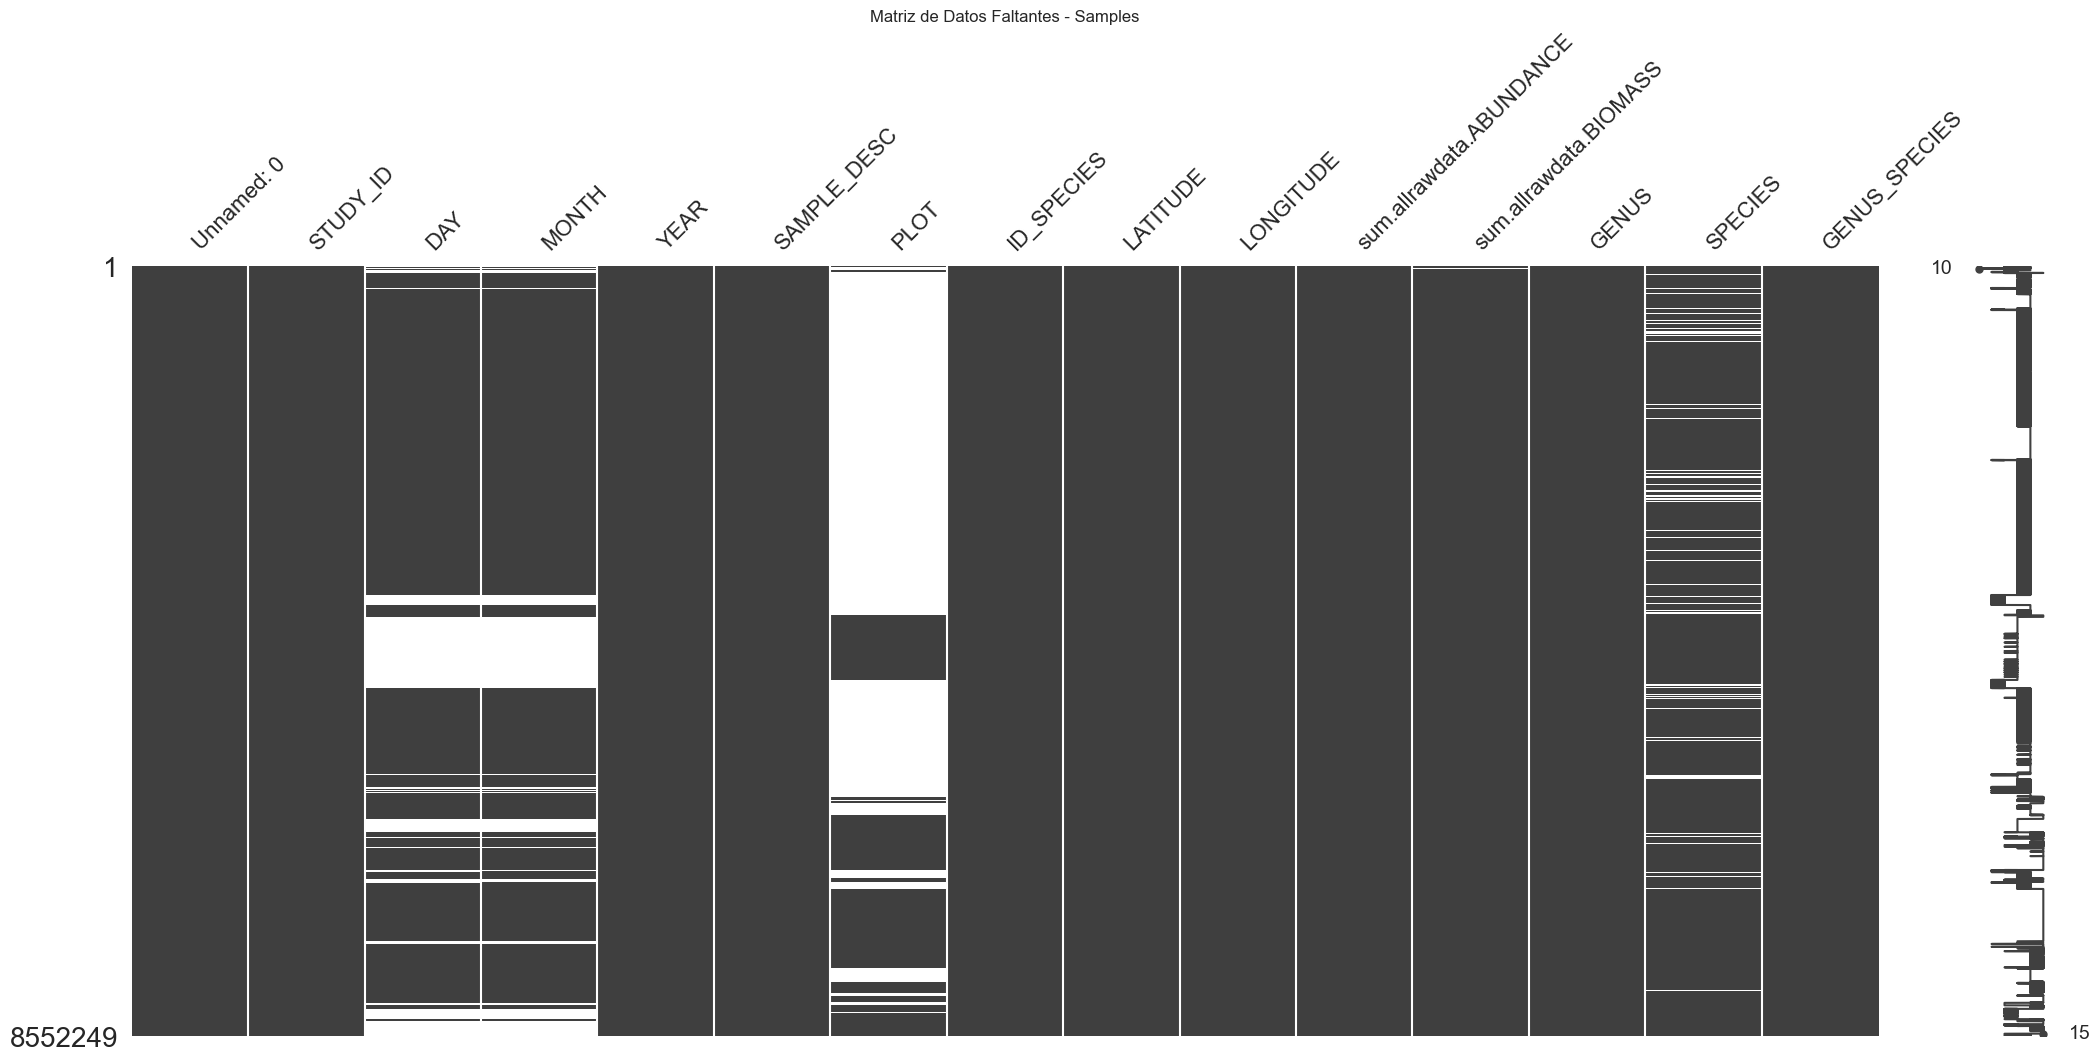

In [5]:
msno.matrix(samples)
plt.title("Matriz de Datos Faltantes - Samples")
plt.show()  

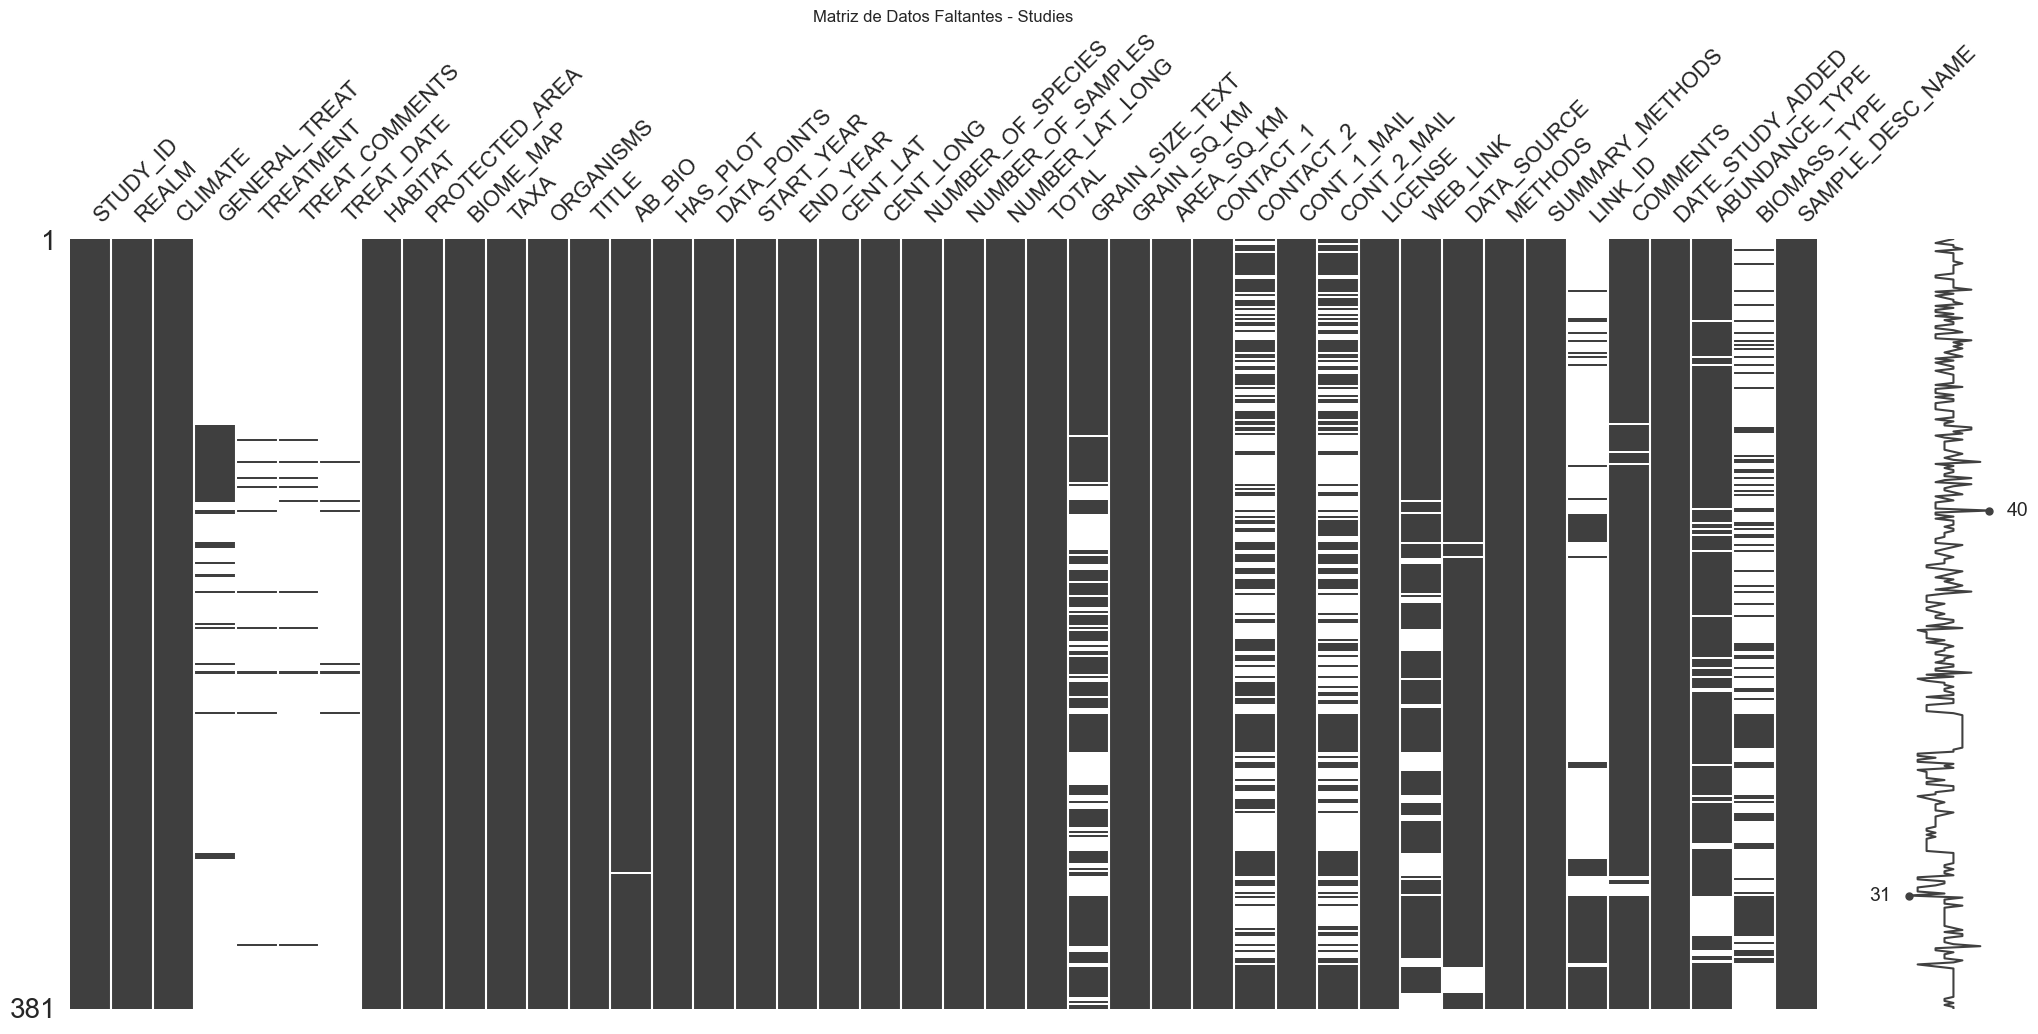

In [6]:
msno.matrix(studies)
plt.title("Matriz de Datos Faltantes - Studies")
plt.show()

## Preparación de los datos

Veamos que para los datasets tenemos datos que no nos sirven para analizar. 

Por ejemplo, para el dataset `studies`, hay varias variables relacionadas con cómo contactar a los autores del estudio, entre otras.

Para el dataset `samples`:

- Day y Month: Ya que lo que nos va a interesar es revisar el cambio en los años, ya que el cambio entre días o meses es casi inperceptible. Además muchos registros no tienen estas variables.
- SAMPLE_DESC: Es una descripción de la muestra tomada, lo que, para análisis, no nos sirve.
- Plot: Es una string que nos dice si el estudio original contiene gráficos, lo cual para este análisis no nos sirve, salvo para contrastar gráficos.

Entre otras que no tienen mucha relevancia en el análisis que quremos realizar:

In [7]:
# Eliminar columnas innecesarias en studies (BioTIMEMetadata)
columns_to_drop_studies = ["GENERAL_TREAT", "TREATMENT", "TREAT_COMMENTS", "TREAT_DATE", 
                           "GRAIN_SIZE_TEXT", "CONTACT_1", "CONTACT_2", "CONT_1_MAIL", "CONT_2_MAIL", 
                           "LICENSE", "WEB_LINK", "DATA_SOURCE", "METHODS", "SUMMARY_METHODS", 
                           "LINK_ID", "COMMENTS", "ABUNDANCE_TYPE", "BIOMASS_TYPE", "SAMPLE_DESC_NAME",
                           "NUMBER_LAT_LONG", "TITLE"]
studies = studies.drop(columns=columns_to_drop_studies, errors='ignore')

In [8]:
# Eliminar columnas innecesarias en samples (BioTIMEQuery)
columns_to_drop_samples = ["DAY", "MONTH", "SAMPLE_DESC", "PLOT", "SPECIES", "Unnamed: 0"]
samples = samples.drop(columns=columns_to_drop_samples, errors='ignore')

A continuación realizamos una limpieza de los datos utilizando el método del rango intercuartílico (IQR) para detectar y eliminar outliers, adicionalmente eliminamos algunas columnas que no son relevantes para nuestro análisis. Calculamos el rango intercuartículo y establecemos cotas con base en este:

In [9]:
# Función para eliminar outliers usando el rango intercuartílico (IQR)
def remove_outliers(df, columns):
    for col in columns:
        if df[col].dtype in ['float64', 'int64']:  # Solo aplicar a columnas numéricas
            
            Q1 = df[col].quantile(0.25)
            Q3 = df[col].quantile(0.75)
            IQR = Q3 - Q1
            lower_bound = Q1 - 1.5 * IQR
            upper_bound = Q3 + 1.5 * IQR
            df = df[(df[col] >= lower_bound) & (df[col] <= upper_bound)]
    
    return df

Para este caso, solo se eliminarán los outliers de las columnas de Biomasa y Abundancia del dataset `samples`. No realizamos filtrado para `studies` pues consideramos que cada registro es valioso debido al tamaño de este dataset.

In [10]:
# Seleccionar columnas numéricas en cada dataset
# numeric_cols_samples = samples.select_dtypes(include=['float64', 'int64']).columns
# numeric_cols_studies = studies.select_dtypes(include=['float64', 'int64']).columns
numeric_cols_samples = ['sum.allrawdata.ABUNDANCE', 'sum.allrawdata.BIOMASS']
numeric_cols_studies = []

# Filtrar outliers en ambos datasets
samples_cleaned = remove_outliers(samples, numeric_cols_samples)
studies_cleaned = remove_outliers(studies, numeric_cols_studies)

Veamos cuántos valores se filtraron:

In [11]:
# Mostrar la cantidad de filas antes y después del filtrado
print(f"Filas en 'samples' antes del filtrado: {len(samples)}, después: {len(samples_cleaned)}")
print(f"Filas en 'studies' antes del filtrado: {len(studies)}, después: {len(studies_cleaned)}")

Filas en 'samples' antes del filtrado: 8552249, después: 5688743
Filas en 'studies' antes del filtrado: 381, después: 381


## Análisis exploratorio de los datos

A continuación presentamos un análisis exploratorio de cada dataset. Primero lo haremos para `samples` y luego para `studies`.

### Dataframe Samples

Dimensiones y muestra de datos:

In [12]:
print("Dimensiones de samples:", samples_cleaned.shape)

Dimensiones de samples: (5688743, 9)


In [13]:
samples_cleaned.head(5)

STUDY_ID  YEAR  ID_SPECIES  LATITUDE  LONGITUDE  sum.allrawdata.ABUNDANCE  \
0        10  1984          22      47.4     -95.12                       1.0   
1        10  1984          23      47.4     -95.12                       3.0   
2        10  1984          24      47.4     -95.12                       1.0   
3        10  1984         607      47.4     -95.12                      12.0   
4        10  1984        1911      47.4     -95.12                       1.0   

   sum.allrawdata.BIOMASS    GENUS    GENUS_SPECIES  
0                     0.0     Acer      Acer rubrum  
1                     0.0     Acer   Acer saccharum  
2                     0.0     Acer    Acer spicatum  
3                     0.0  Corylus  Corylus cornuta  
4                     0.0  Populus  Populus pinnata

Información general:

In [14]:
print(samples_cleaned.info(), "\n")

<class 'pandas.core.frame.DataFrame'>
Index: 5688743 entries, 0 to 8526066
Data columns (total 9 columns):
 #   Column                    Dtype  
---  ------                    -----  
 0   STUDY_ID                  int64  
 1   YEAR                      int64  
 2   ID_SPECIES                int64  
 3   LATITUDE                  float64
 4   LONGITUDE                 float64
 5   sum.allrawdata.ABUNDANCE  float64
 6   sum.allrawdata.BIOMASS    float64
 7   GENUS                     object 
 8   GENUS_SPECIES             object 
dtypes: float64(4), int64(3), object(2)
memory usage: 434.0+ MB
None 



Estadísticos descriptivos:

In [15]:
print(samples_cleaned.describe(), "\n")

           STUDY_ID          YEAR    ID_SPECIES      LATITUDE     LONGITUDE  \
count  5.688743e+06  5.688743e+06  5.688743e+06  5.688743e+06  5.688743e+06   
mean   2.159586e+02  1.993370e+03  1.647243e+04  3.097264e+01 -3.687220e+01   
std    1.028462e+02  1.510873e+01  1.500457e+04  2.824556e+01  8.664221e+01   
min    1.000000e+01  1.874000e+03  1.000000e+00 -8.898167e+01 -1.800000e+02   
25%    1.290000e+02  1.986000e+03  4.598000e+03  2.851000e+01 -9.647200e+01   
50%    1.950000e+02  1.996000e+03  8.740000e+03  3.916470e+01 -7.064000e+01   
75%    2.540000e+02  2.003000e+03  2.663200e+04  4.674256e+01 -2.001360e+00   
max    5.160000e+02  2.016000e+03  5.205700e+04  8.970000e+01  1.800000e+02   

       sum.allrawdata.ABUNDANCE  sum.allrawdata.BIOMASS  
count              5.688743e+06            5.688743e+06  
mean               2.453589e+00            7.096013e-02  
std                2.720647e+00            2.048569e-01  
min                0.000000e+00            0.000000e+00 

Conteo de valores faltantes:

In [16]:
# Conteo de valores faltantes por columna
print("Valores faltantes en samples:")
print(samples_cleaned.isnull().sum(), "\n")

Valores faltantes en samples:
STUDY_ID                    0
YEAR                        0
ID_SPECIES                  0
LATITUDE                    0
LONGITUDE                   0
sum.allrawdata.ABUNDANCE    0
sum.allrawdata.BIOMASS      0
GENUS                       0
GENUS_SPECIES               0
dtype: int64 



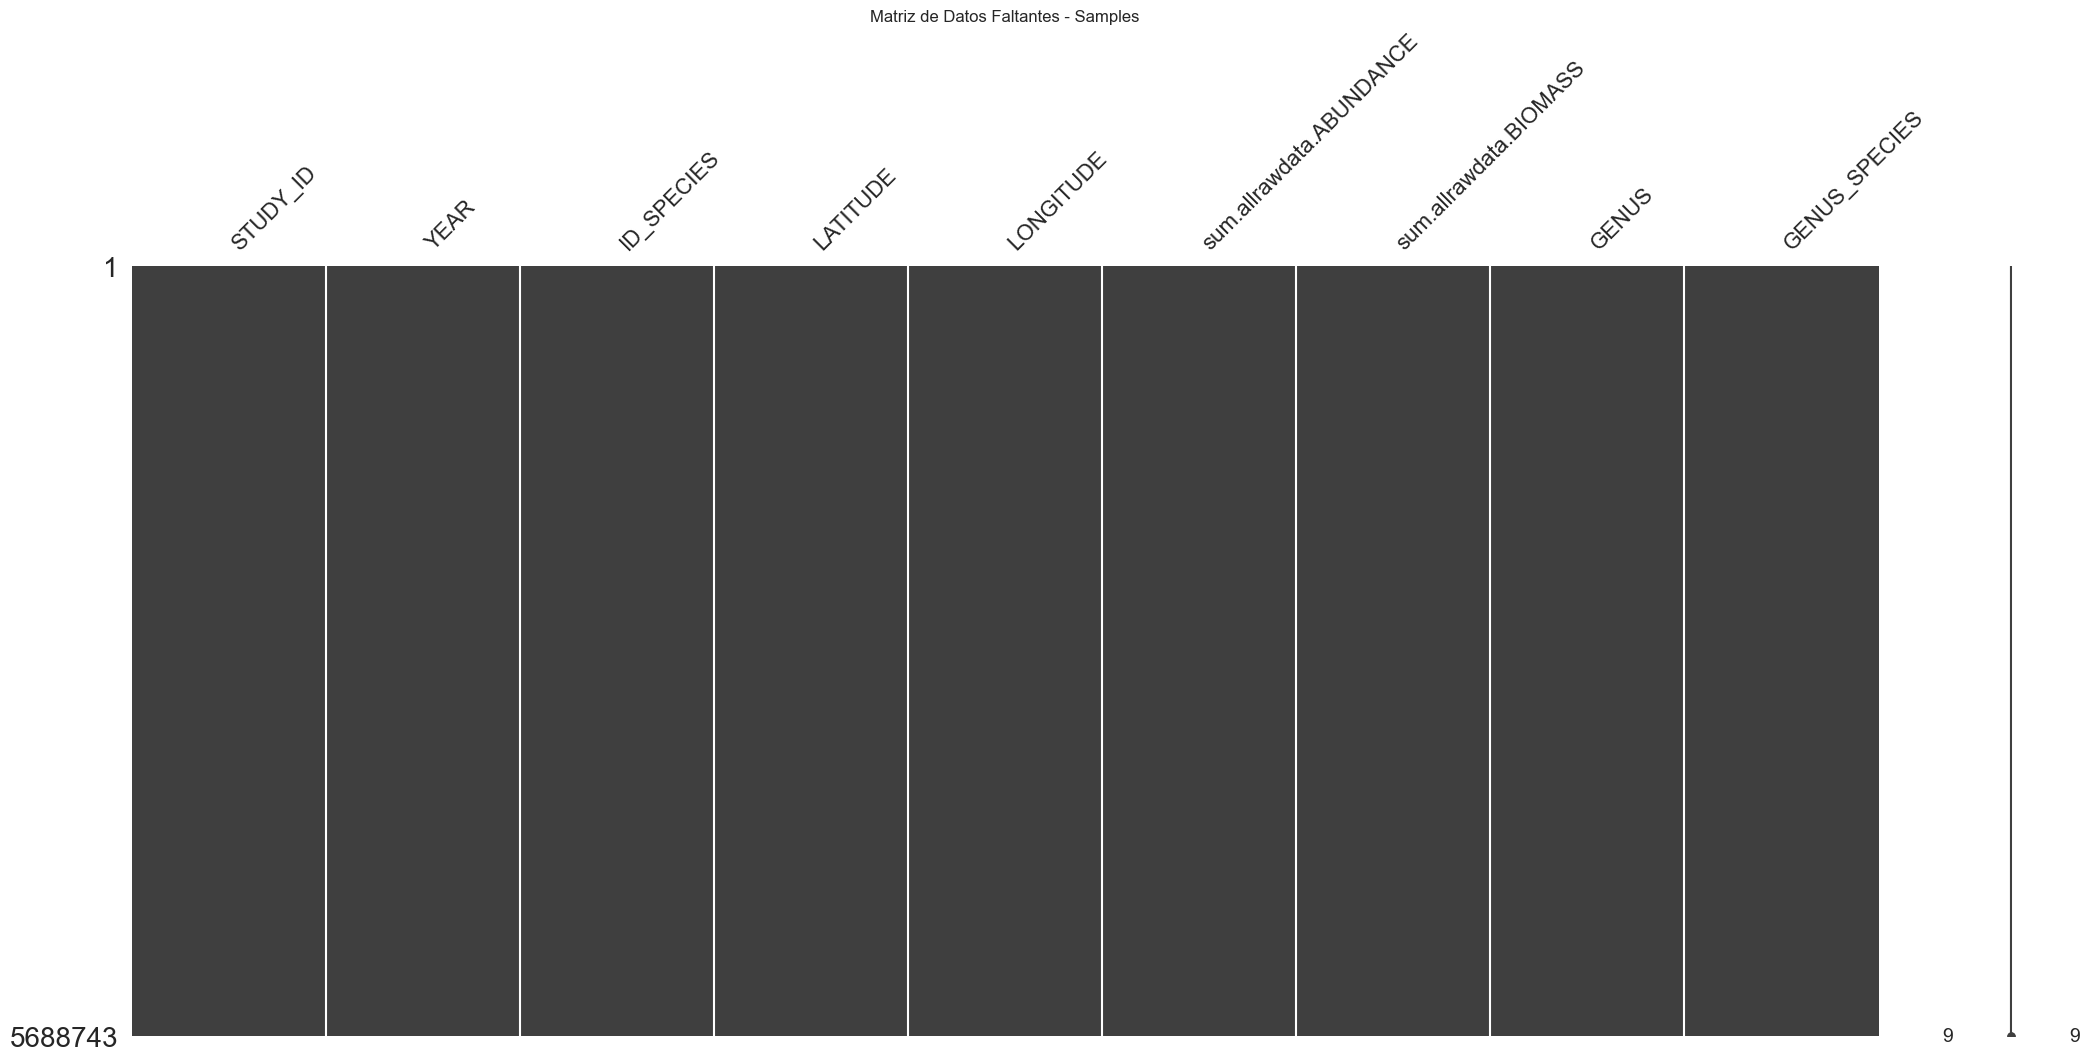

In [17]:
msno.matrix(samples_cleaned)
plt.title("Matriz de Datos Faltantes - Samples")
plt.show()  

Histogramas para variables numéricas

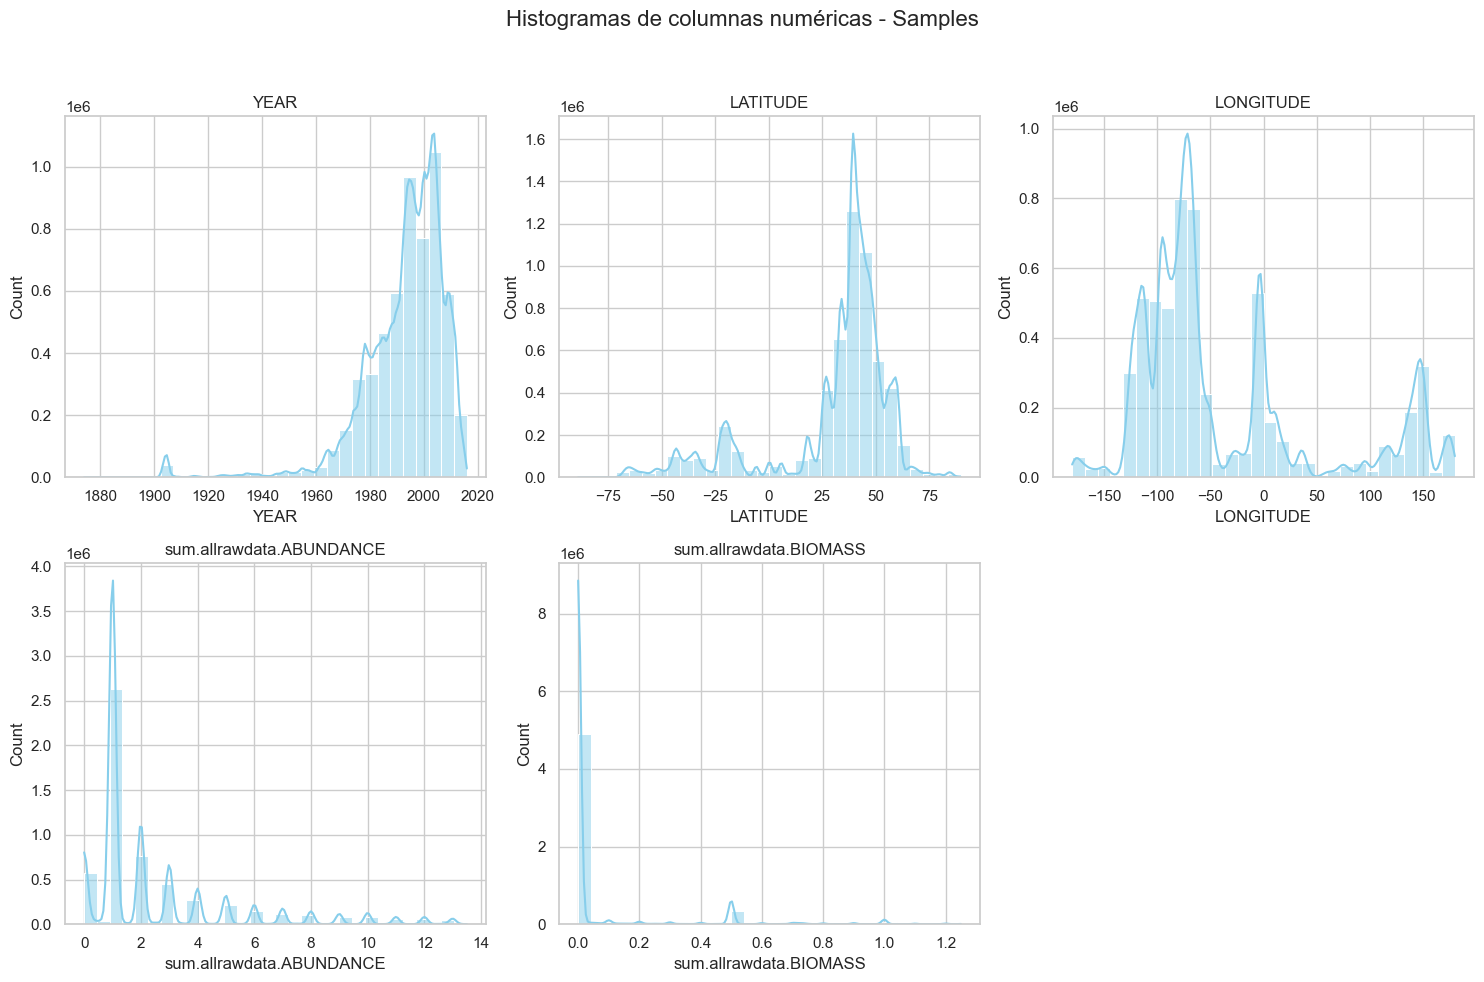

In [19]:
numeric_cols = ['YEAR', 'LATITUDE', 'LONGITUDE', 
                'sum.allrawdata.ABUNDANCE', 'sum.allrawdata.BIOMASS'] # 
# Configura el estilo de seaborn para gráficos más atractivos
sns.set(style="whitegrid")

# Define el tamaño de la figura y crea subplots
fig, axs = plt.subplots(2, 3, figsize=(15, 10))
axs = axs.flatten()

for i, col in enumerate(numeric_cols):
  # Grafica cada columna con histograma y KDE
  sns.histplot(data=samples_cleaned, x=col, bins=30, kde=True, ax=axs[i], color="skyblue")
  axs[i].set_title(col)

# Si hay subplots vacíos, elimínalos
if len(numeric_cols) < len(axs):
  for j in range(len(numeric_cols), len(axs)):
    fig.delaxes(axs[j])

fig.suptitle("Histogramas de columnas numéricas - Samples", fontsize=16)
plt.tight_layout(rect=[0, 0, 1, 0.95])
plt.show()

Matriz de correlaciones:

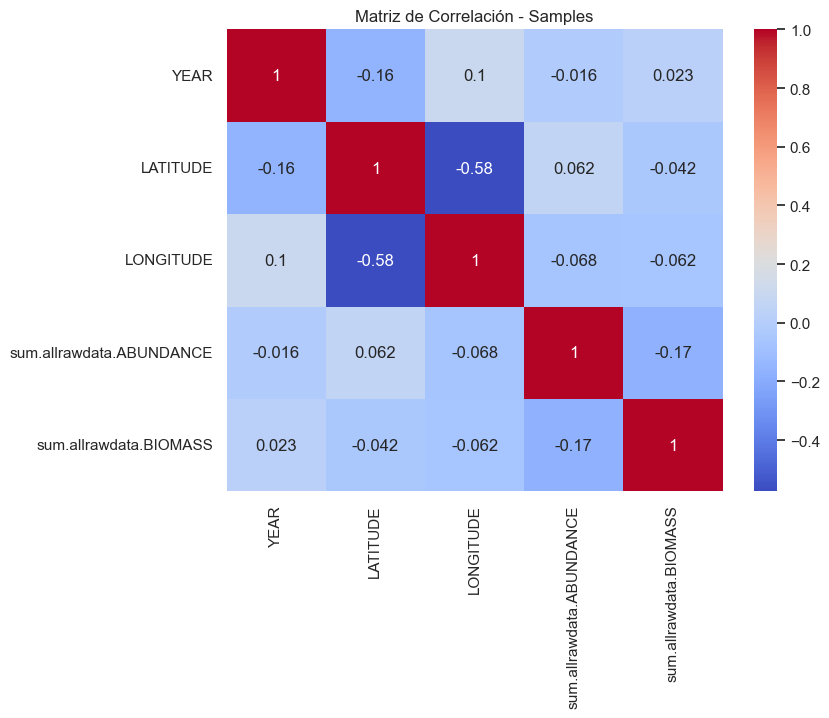

In [20]:
# Matriz de correlación para variables numéricas
corr = samples_cleaned[numeric_cols].corr()
plt.figure(figsize=(8, 6))
sns.heatmap(corr, annot=True, cmap="coolwarm")
plt.title("Matriz de Correlación - Samples")
plt.show()

La matriz de correlación de Pearson nos indica que no hay ningun par de variables fuertemente relacionadas. Más adelante investigaremos estas relaciones.

### Dataframe Studies

Dimensión y muestra de los datos:

In [21]:
print("Dimensiones de studies:", studies_cleaned.shape)

Dimensiones de studies: (381, 21)


In [22]:
studies_cleaned.head(5)

STUDY_ID        REALM    CLIMATE           HABITAT  PROTECTED_AREA  \
0        10  Terrestrial  Temperate          Woodland           False   
1        18  Terrestrial  Temperate  Sagebrush steppe           False   
2        33       Marine  Temperate      Seaweed beds           False   
3        39  Terrestrial  Temperate  Deciduous forest           False   
4        41  Terrestrial  Temperate          Woodland           False   

                               BIOME_MAP                TAXA  \
0  Temperate broadleaf and mixed forests  Terrestrial plants   
1           Deserts and xeric shrublands  Terrestrial plants   
2    Temperate shelf and seas ecoregions       Marine plants   
3  Temperate broadleaf and mixed forests               Birds   
4  Temperate broadleaf and mixed forests               Birds   

                 ORGANISMS AB_BIO HAS_PLOT  ...  START_YEAR  END_YEAR  \
0             woody plants      A        Y  ...        1984      1996   
1  sagebrush steppe plants      A        Y  ...        1923      1973   
2            phytoplankton      A        S  ...        1992      2009   
3                    birds      A        S  ...        1970      2015   
4                    birds      A        S  ...        1923      1940   

   CENT_LAT  CENT_LONG  NUMBER_OF_SPECIES  NUMBER_OF_SAMPLES  TOTAL  \
0     47.40    -95.120                 25                191   1406   
1     44.33   -112.330                 98                542   8034   
2     50.25     -4.217                170                  1  17841   
3     43.91    -71.750                 52                 45    959   
4     39.50    -82.480                 56                 10    418   

    GRAIN_SQ_KM  AREA_SQ_KM  DATE_STUDY_ADDED  
0  4.000000e-06    0.000006            Oct-12  
1  1.000000e-06    0.000006            Oct-12  
2  1.580000e-08    0.000006            Oct-12  
3  5.000000e-02    0.100000            Oct-12  
4  2.800000e-01    0.000005            Oct-12  

[5 rows x 21 columns]

Información general

In [23]:
print(studies_cleaned.info(), "\n")

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 381 entries, 0 to 380
Data columns (total 21 columns):
 #   Column             Non-Null Count  Dtype  
---  ------             --------------  -----  
 0   STUDY_ID           381 non-null    int64  
 1   REALM              381 non-null    object 
 2   CLIMATE            381 non-null    object 
 3   HABITAT            381 non-null    object 
 4   PROTECTED_AREA     381 non-null    bool   
 5   BIOME_MAP          381 non-null    object 
 6   TAXA               381 non-null    object 
 7   ORGANISMS          381 non-null    object 
 8   AB_BIO             380 non-null    object 
 9   HAS_PLOT           381 non-null    object 
 10  DATA_POINTS        381 non-null    int64  
 11  START_YEAR         381 non-null    int64  
 12  END_YEAR           381 non-null    int64  
 13  CENT_LAT           381 non-null    float64
 14  CENT_LONG          381 non-null    float64
 15  NUMBER_OF_SPECIES  381 non-null    int64  
 16  NUMBER_OF_SAMPLES  381 non

Estadísticos descriptivos:

In [24]:
print(studies_cleaned.describe(), "\n")

         STUDY_ID  DATA_POINTS   START_YEAR     END_YEAR    CENT_LAT  \
count  381.000000   381.000000   381.000000   381.000000  381.000000   
mean   318.818898    13.249344  1985.910761  2003.603675   30.532986   
std    142.255094    12.785200    21.370969    13.176849   31.272872   
min     10.000000     2.000000  1874.000000  1909.000000  -77.665463   
25%    213.000000     4.000000  1977.000000  2000.000000   23.948044   
50%    338.000000     9.000000  1990.000000  2008.000000   39.095300   
75%    436.000000    18.000000  2000.000000  2012.000000   49.100250   
max    548.000000    97.000000  2015.000000  2018.000000   80.624583   

        CENT_LONG  NUMBER_OF_SPECIES  NUMBER_OF_SAMPLES          TOTAL  \
count  381.000000         381.000000         381.000000     381.000000   
mean   -23.232297         199.283465        3675.249344   23021.133858   
std     85.023922         530.038210       16660.664333   74875.628247   
min   -178.000000           3.000000           1.000000

Conteo de datos 

In [25]:
# Conteo de valores faltantes por columna
print("Valores faltantes en studies:")
print(studies_cleaned.isnull().sum(), "\n")

Valores faltantes en studies:
STUDY_ID             0
REALM                0
CLIMATE              0
HABITAT              0
PROTECTED_AREA       0
BIOME_MAP            0
TAXA                 0
ORGANISMS            0
AB_BIO               1
HAS_PLOT             0
DATA_POINTS          0
START_YEAR           0
END_YEAR             0
CENT_LAT             0
CENT_LONG            0
NUMBER_OF_SPECIES    0
NUMBER_OF_SAMPLES    0
TOTAL                0
GRAIN_SQ_KM          0
AREA_SQ_KM           0
DATE_STUDY_ADDED     0
dtype: int64 



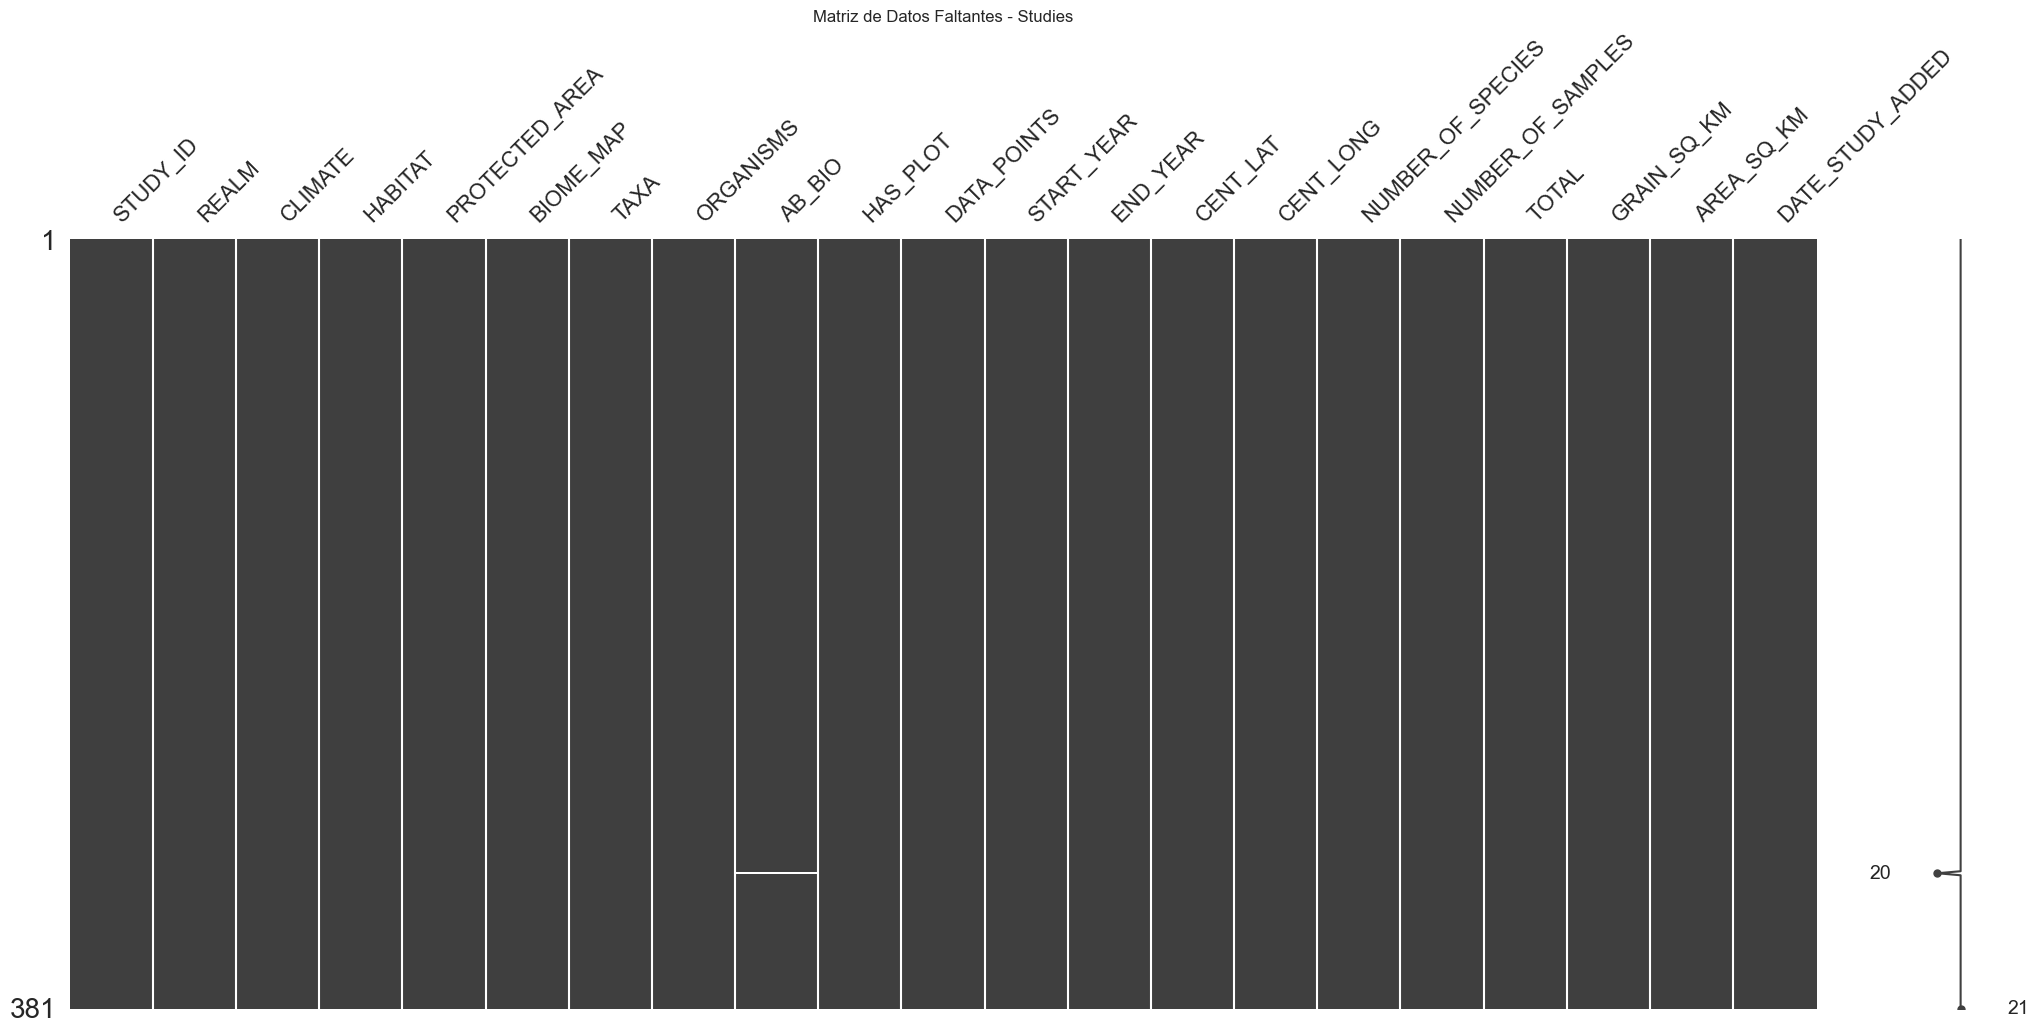

In [ ]:
msno.matrix(studies_cleaned)
plt.title("Matriz de Datos Faltantes - Studies")
plt.show()

Histogramas para variables numéricas

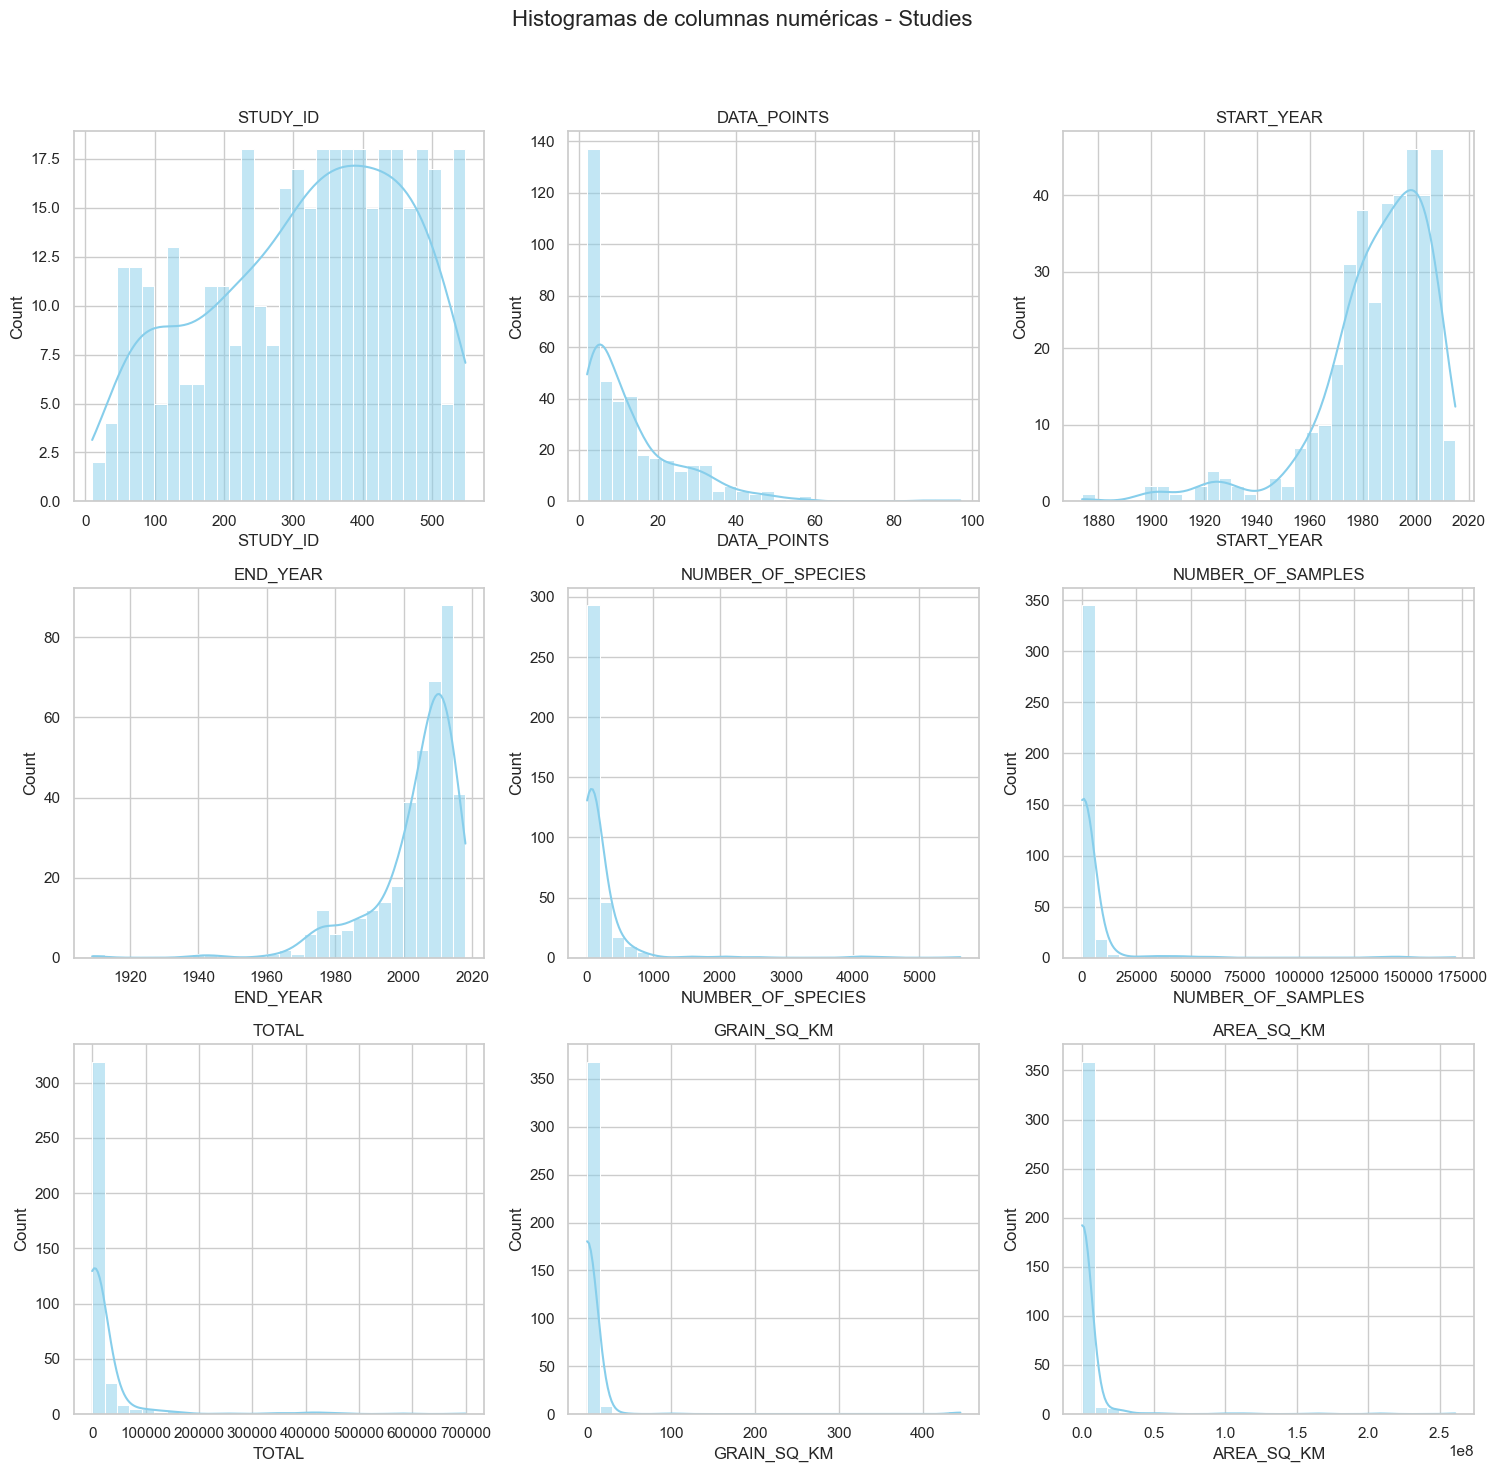

In [26]:
numeric_cols = ['STUDY_ID', 'DATA_POINTS', 'START_YEAR', 'END_YEAR', 
                'NUMBER_OF_SPECIES', 'NUMBER_OF_SAMPLES', 'TOTAL', 
                'GRAIN_SQ_KM', 'AREA_SQ_KM']
# Configura el estilo de seaborn para gráficos más atractivos
sns.set(style="whitegrid")

# Define el tamaño de la figura y crea subplots
fig, axs = plt.subplots(3, 3, figsize=(15, 15))
axs = axs.flatten()

for i, col in enumerate(numeric_cols):
  # Grafica cada columna con histograma y KDE
  sns.histplot(data=studies_cleaned, x=col, bins=30, kde=True, ax=axs[i], color="skyblue")
  axs[i].set_title(col)

# Si hay subplots vacíos, elimínalos
if len(numeric_cols) < len(axs):
  for j in range(len(numeric_cols), len(axs)):
    fig.delaxes(axs[j])

fig.suptitle("Histogramas de columnas numéricas - Studies", fontsize=16)
plt.tight_layout(rect=[0, 0, 1, 0.95])
plt.show()

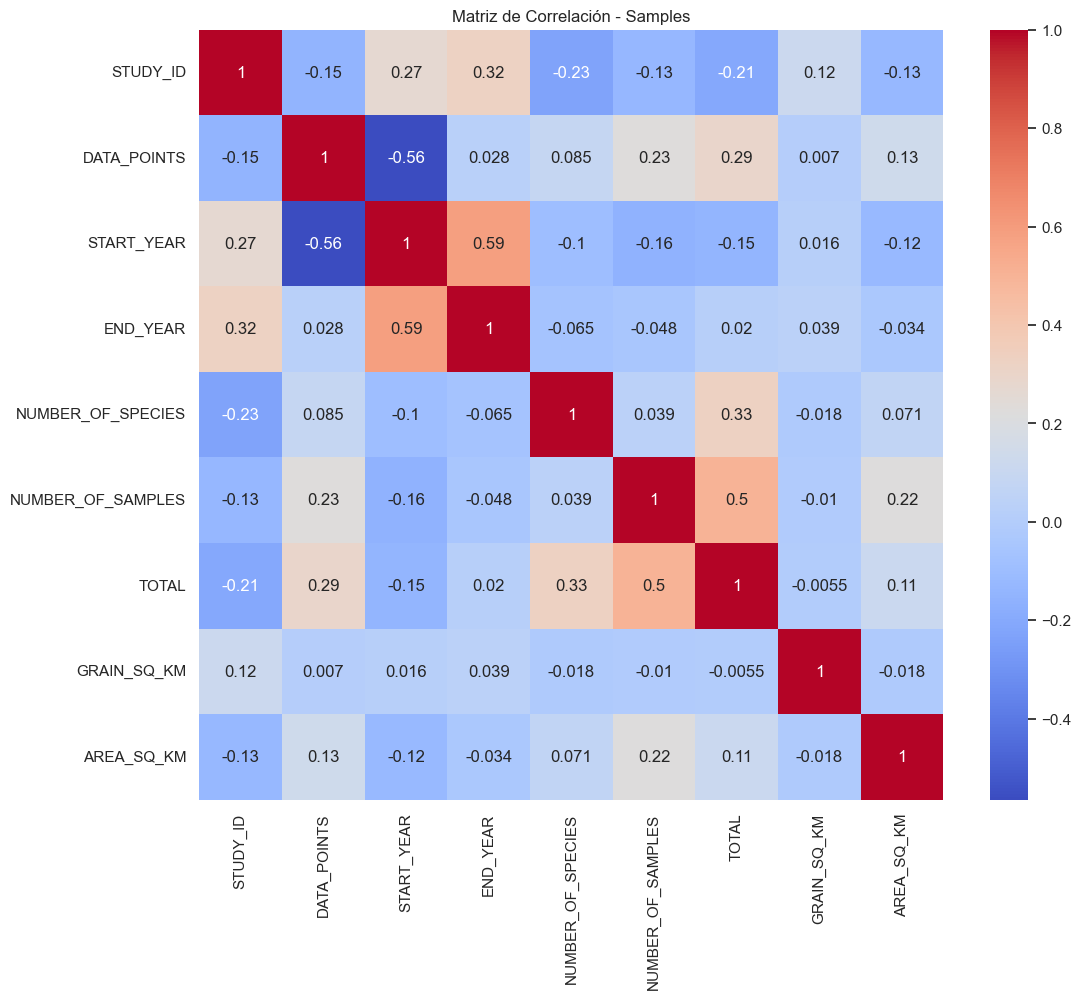

In [27]:
# Matriz de correlación para variables numéricas
corr = studies_cleaned[numeric_cols].corr()
plt.figure(figsize=(12, 10))
sns.heatmap(corr, annot=True, cmap="coolwarm")
plt.title("Matriz de Correlación - Samples")
plt.show()

Implementamos una función para ver gráficos de conteo para algunas variables categóricas:

In [28]:
def plot_count(feature, title, df, size=1):
  import matplotlib.pyplot as plt
  import seaborn as sns
  # Configurar el tema para un fondo limpio y moderno
  sns.set_theme(style="whitegrid")
  
  f, ax = plt.subplots(1, 1, figsize=(4*size, 4))
  total = float(len(df))
  # Ordenar las categorías según su frecuencia (top 20)
  order = df[feature].value_counts().index[:20]
  
  # Crear el countplot
  g = sns.countplot(
    y=df[feature],
    order=order,
    palette="viridis",
    hue=df[feature],
    legend=False,
    ax=ax
  )
  
  # Título y etiquetas de ejes con mayor tamaño y énfasis
  ax.set_title(f"Número y porcentaje de {title}", fontsize=14, fontweight="bold")
  ax.set_xlabel("Conteo", fontsize=12)
  ax.set_ylabel(title, fontsize=12)
  
  # Añadir etiquetas de porcentaje en cada barra
  for p in ax.patches:
    width = p.get_width()
    percentage = 100 * width / total
    ax.text(
      width + (total * 0.005),
      p.get_y() + p.get_height() / 2,
      f"{percentage:1.2f}%",
      fontsize=10,
      color="black",
      va="center"
    )
  
  # Eliminar bordes superiores y derechos para una apariencia más limpia
  sns.despine(left=True, bottom=True)
  plt.tight_layout()
  plt.show()


Veamos el número y porcentaje de las especies por cada uno de los reinos globales

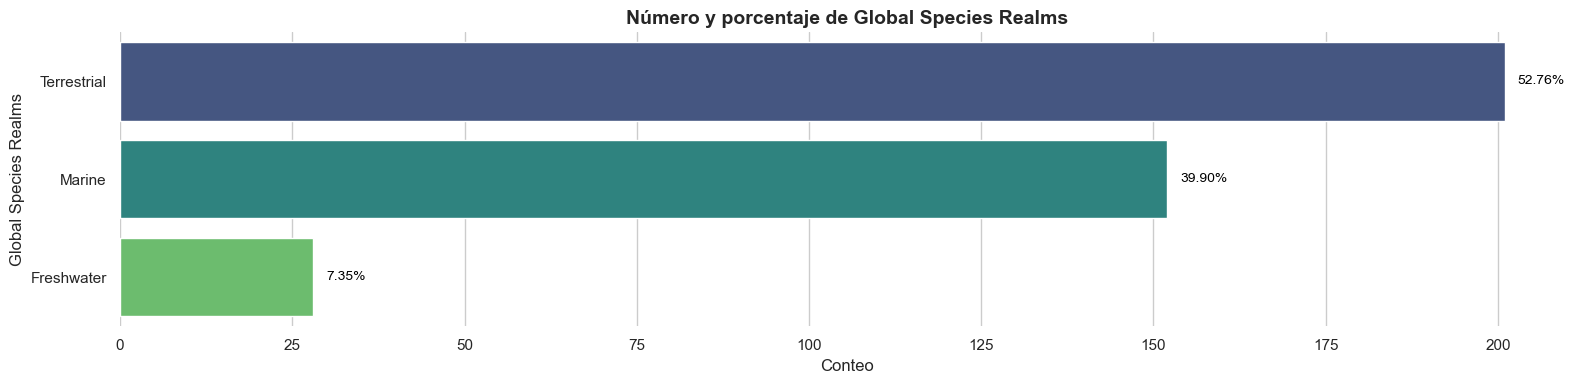

In [ ]:
plot_count("REALM", "Global Species Realms", studies, 4)

Podemos hacer lo mismo del gráfico anterior, pero esta vez para climas en lugar de ecosistemas:

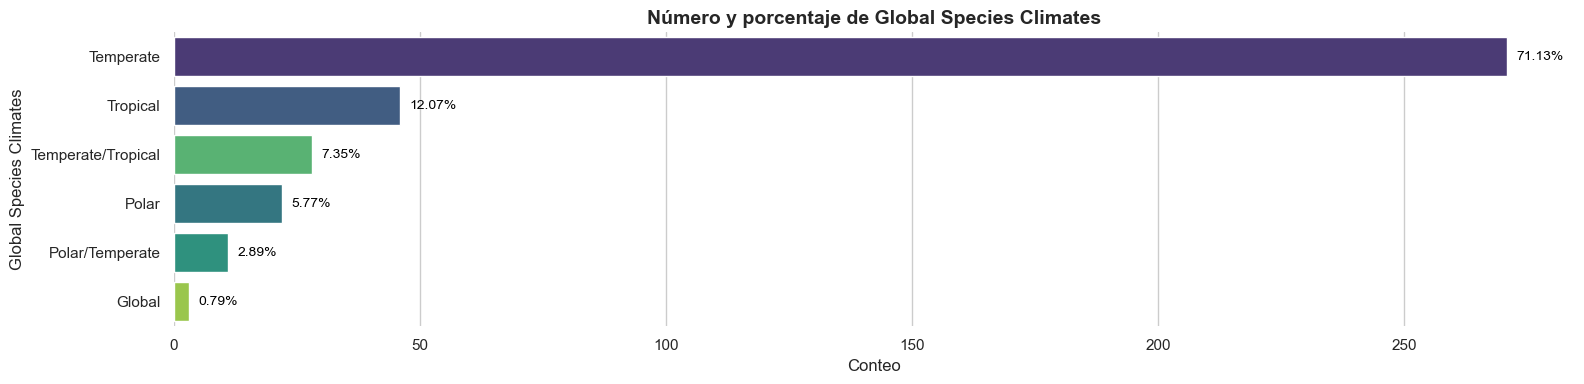

In [ ]:
plot_count("CLIMATE", "Global Species Climates", studies,4)

También podemos observar el numero y porcentaje de especies respecto a si el territorio es protegido o no. De aquí vemos que la mayoría de los estudios fueron llevados a cabo en zonas no protegidas.

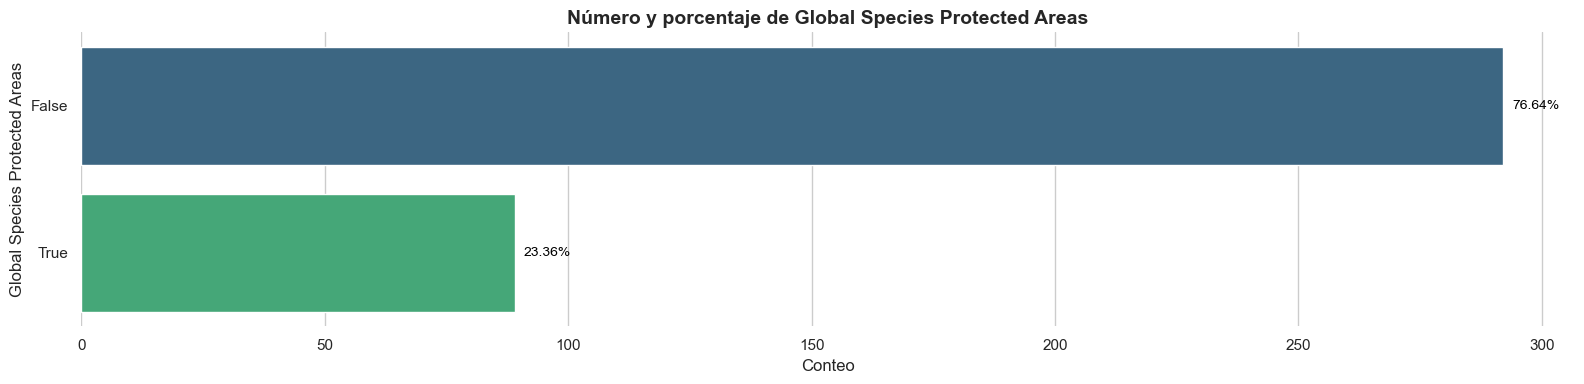

In [ ]:
plot_count("PROTECTED_AREA", "Global Species Protected Areas", studies,4)

También podemos ver el numero y porcentaje del tipo de especies en los estudios

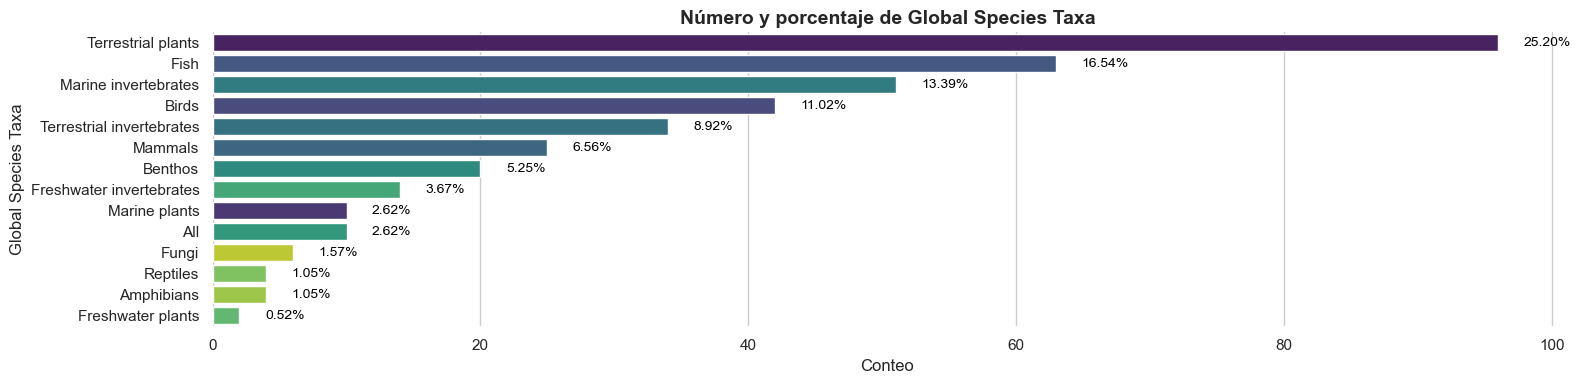

In [ ]:
plot_count("TAXA", "Global Species Taxa", studies,4)

Y el porcentaje de los distintos Hábitats:

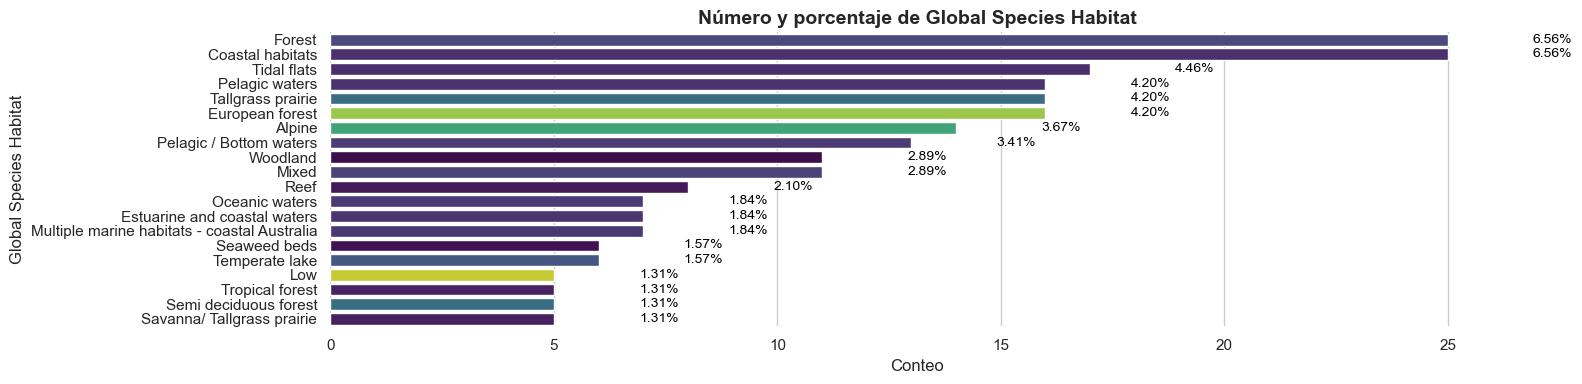

In [ ]:
plot_count("HABITAT", "Global Species Habitat", studies,4)

El porcentaje de los distintos biomas:

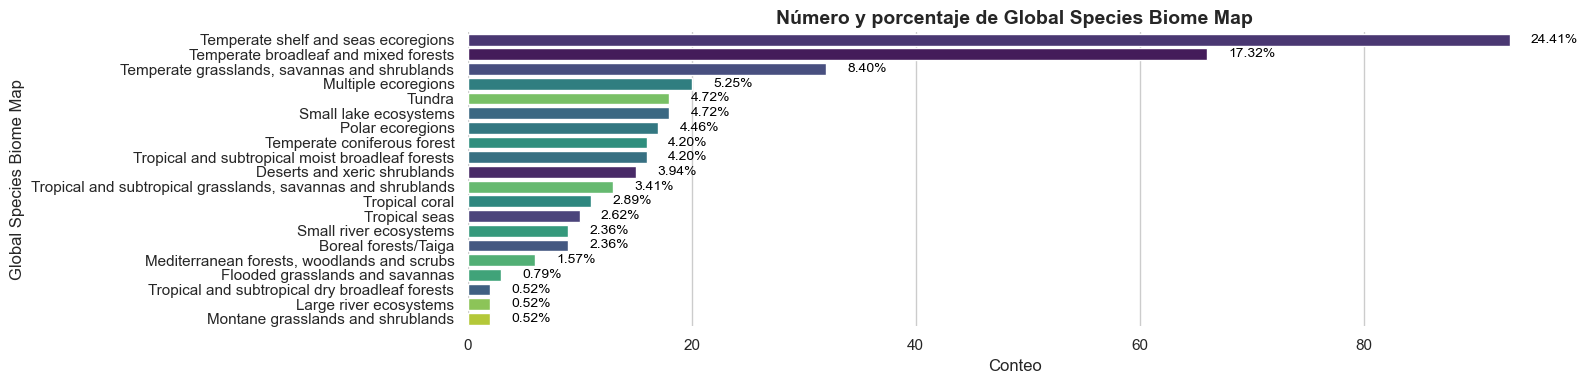

In [ ]:
plot_count("BIOME_MAP", "Global Species Biome Map", studies,4)

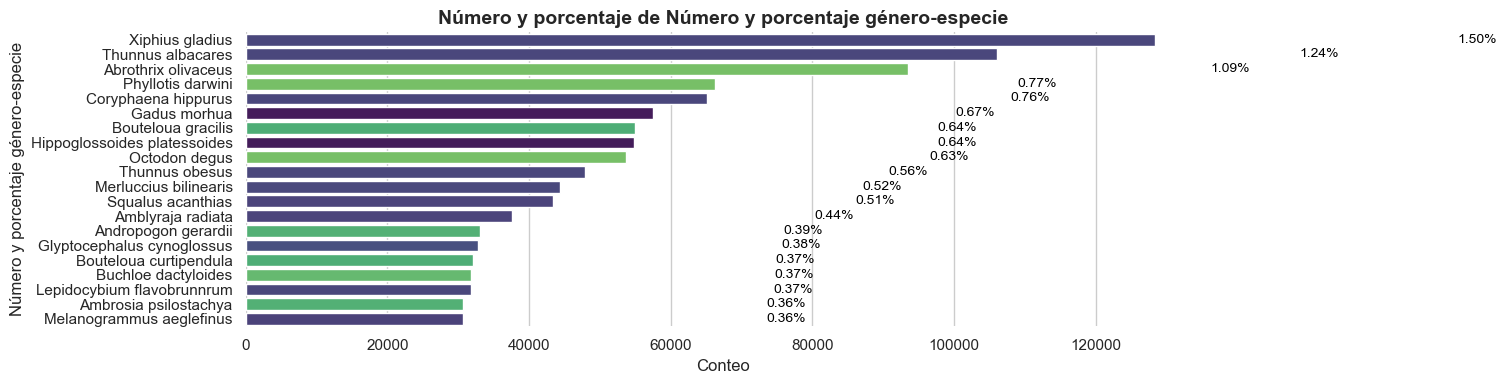

In [29]:
plot_count("GENUS_SPECIES", "Número y porcentaje género-especie", samples,4)

## Análisis temporal

Veamos algunas tendencias anuales:

In [30]:
# Agrupar por año para obtener la abundancia y biomasa promedio
yearly_data = samples.groupby('YEAR').agg({
  'sum.allrawdata.ABUNDANCE': 'mean',
  'sum.allrawdata.BIOMASS': 'mean'
}).reset_index()

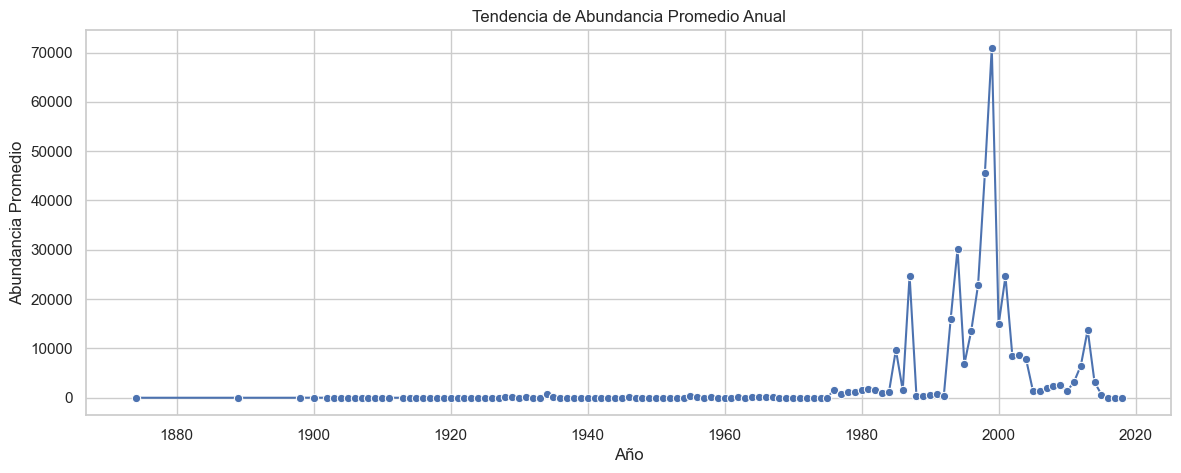

In [31]:
# Gráfica: Abundancia promedio anual
plt.figure(figsize=(14, 5))
sns.lineplot(data=yearly_data, x='YEAR', y='sum.allrawdata.ABUNDANCE', marker='o')
plt.title('Tendencia de Abundancia Promedio Anual')
plt.xlabel('Año')
plt.ylabel('Abundancia Promedio')
plt.grid(True)
plt.show()

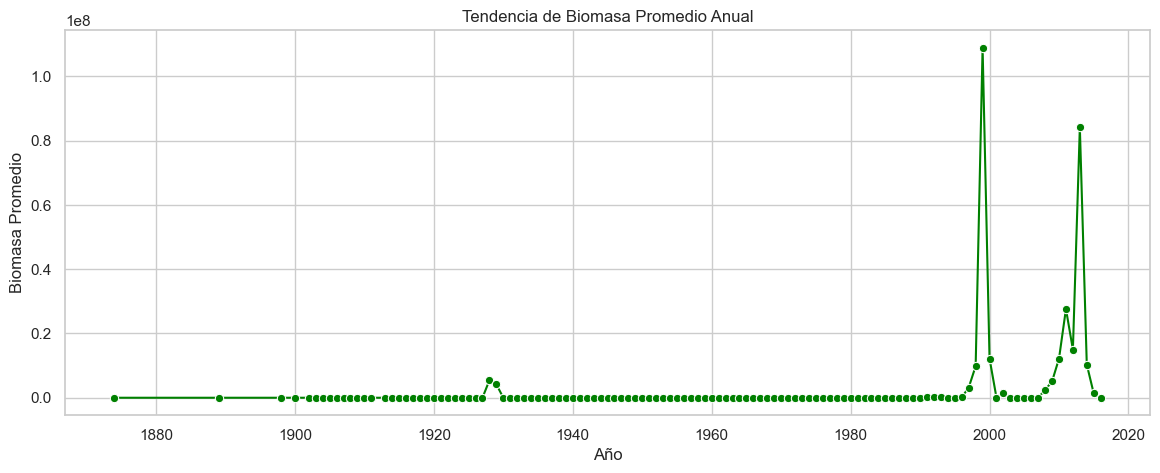

In [32]:
# Gráfica: Biomasa promedio anual
plt.figure(figsize=(14, 5))
sns.lineplot(data=yearly_data, x='YEAR', y='sum.allrawdata.BIOMASS', marker='o', color='green')
plt.title('Tendencia de Biomasa Promedio Anual')
plt.xlabel('Año')
plt.ylabel('Biomasa Promedio')
plt.grid(True)
plt.show()

## Análisis geoespacial

Distribución geográfica según Abundancia

In [55]:
import geopandas as gpd
import cartopy.crs as ccrs
import cartopy.feature as cfeature

Text(0.5, 1.0, 'Distribución Geográfica de Muestras - Abundancia')

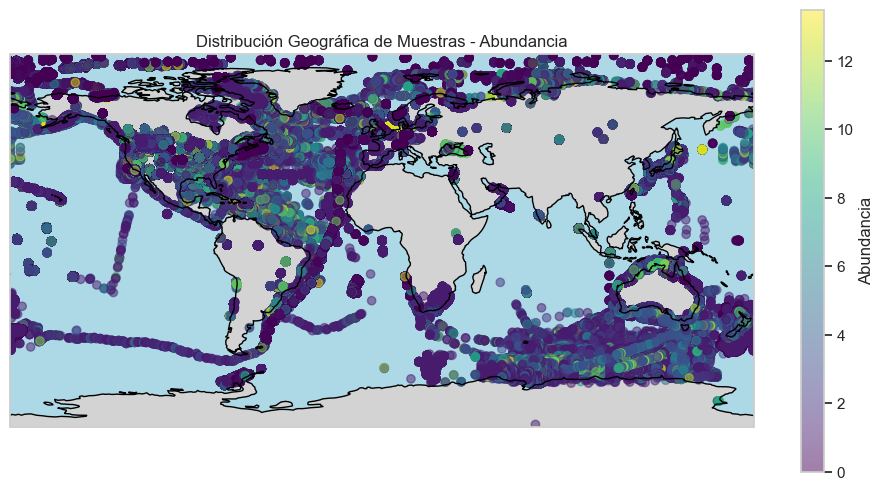

In [ ]:
# Crear la figura y los ejes con proyección geográfica
fig, ax = plt.subplots(figsize=(12, 6), subplot_kw={'projection': ccrs.PlateCarree()})

# Agregar el mapa base (costas, fronteras, océanos, etc.)
ax.add_feature(cfeature.LAND, facecolor='lightgray')
ax.add_feature(cfeature.OCEAN, facecolor='lightblue')
ax.add_feature(cfeature.COASTLINE, edgecolor='black')

# Graficar los puntos de abundancia
scatter = ax.scatter(
    samples_cleaned['LONGITUDE'], samples_cleaned['LATITUDE'], 
    c=samples_cleaned['sum.allrawdata.ABUNDANCE'], 
    cmap='viridis', alpha=0.5, transform=ccrs.PlateCarree()
)

# Agregar barra de color y etiquetas
plt.colorbar(scatter, label='Abundancia')
ax.set_title("Distribución Geográfica de Muestras - Abundancia")

Text(0.5, 1.0, 'Distribución Geográfica de Muestras - Biomasa')

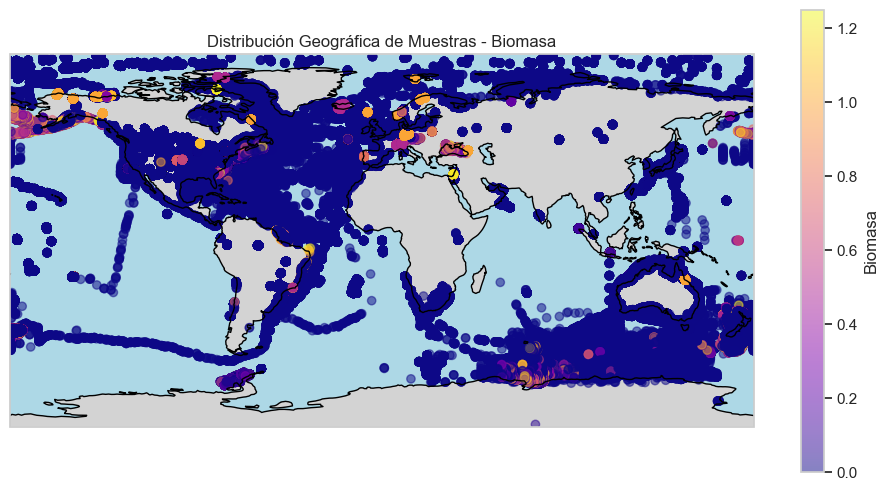

In [ ]:
# Crear la figura y los ejes con proyección geográfica
fig, ax = plt.subplots(figsize=(12, 6), subplot_kw={'projection': ccrs.PlateCarree()})

# Agregar el mapa base (costas, fronteras, océanos, etc.)
ax.add_feature(cfeature.LAND, facecolor='lightgray')
ax.add_feature(cfeature.OCEAN, facecolor='lightblue')
ax.add_feature(cfeature.COASTLINE, edgecolor='black')

# Graficar los puntos de abundancia
scatter = ax.scatter(
    samples_cleaned['LONGITUDE'], samples_cleaned['LATITUDE'], 
    c=samples_cleaned['sum.allrawdata.BIOMASS'], 
    cmap='plasma', alpha=0.5, transform=ccrs.PlateCarree()
)

# Agregar barra de color y etiquetas
plt.colorbar(scatter, label='Biomasa')
ax.set_title("Distribución Geográfica de Muestras - Biomasa")



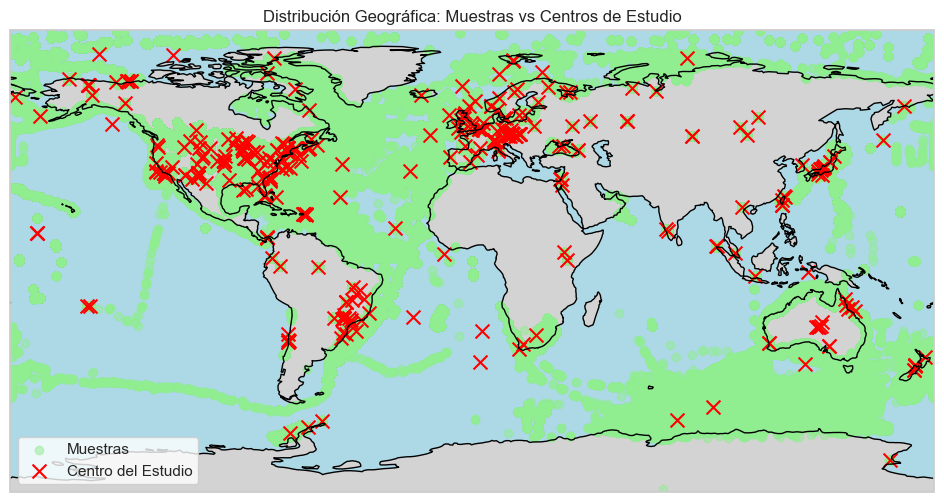

In [ ]:
# Crear la figura y los ejes con proyección geográfica
fig, ax = plt.subplots(figsize=(12, 6), subplot_kw={'projection': ccrs.PlateCarree()})

# Agregar el mapa base (costas, fronteras, océanos, etc.)
ax.add_feature(cfeature.LAND, facecolor='lightgray')
ax.add_feature(cfeature.OCEAN, facecolor='lightblue')
ax.add_feature(cfeature.COASTLINE, edgecolor='black')

# Comparación espacial: Muestras vs Centros de Estudio
ax.scatter(
  samples_cleaned['LONGITUDE'], samples_cleaned['LATITUDE'],
  c='lightgreen', alpha=0.5, label='Muestras', transform=ccrs.PlateCarree()
)
ax.scatter(
  studies_cleaned['CENT_LONG'], studies_cleaned['CENT_LAT'],
  c='red', marker='x', s=100, label='Centro del Estudio', 
  transform=ccrs.PlateCarree()
)
plt.title('Distribución Geográfica: Muestras vs Centros de Estudio')
plt.xlabel('Longitud')
plt.ylabel('Latitud')
plt.legend(loc='lower left')
plt.show()

Podemos ver como se distribuyen geográficamente los hábitats:

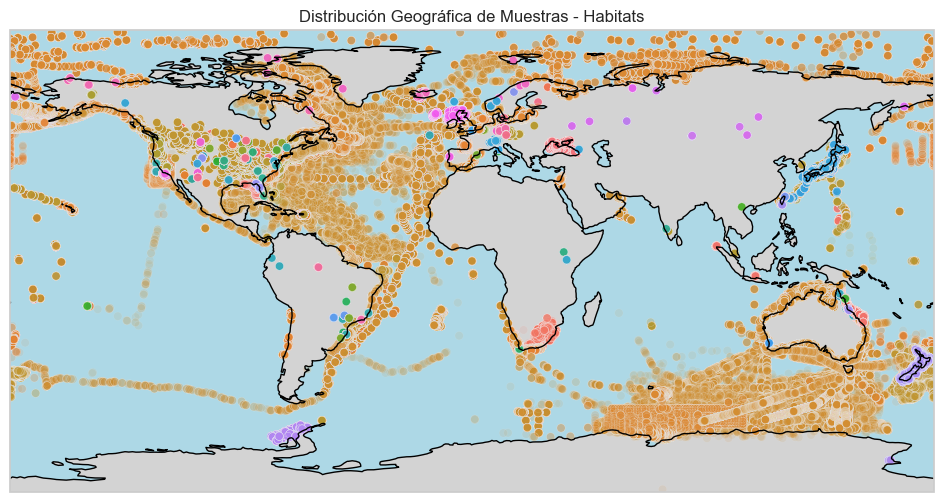

In [207]:
import matplotlib.patches as mpatches

merged_data = samples.merge(studies[['STUDY_ID', 'HABITAT']], on='STUDY_ID', how='left')
merged_data['HABITAT'] = merged_data['HABITAT'].astype(str)

# Crear la figura y los ejes con proyección geográfica
fig, ax = plt.subplots(figsize=(12, 6), subplot_kw={'projection': ccrs.PlateCarree()})
# Agregar el mapa base (costas, fronteras, océanos, etc.)
ax.add_feature(cfeature.LAND, facecolor='lightgray')
ax.add_feature(cfeature.OCEAN, facecolor='lightblue')
ax.add_feature(cfeature.COASTLINE, edgecolor='black')

sns.scatterplot(
    data=merged_data, 
    x="LONGITUDE", 
    y="LATITUDE", 
    hue="HABITAT", 
    alpha=0.1,
    legend=False,
    transform=ccrs.PlateCarree(),
    ax=ax
)


#plt.legend(loc='lower left')
plt.title("Distribución Geográfica de Muestras - Habitats")
plt.xlabel("Longitud")
plt.ylabel("Latitud")
plt.show()

Podemos ver la distribución de áreas protegidas y no protegidas:

<Figure size 900x600 with 0 Axes>

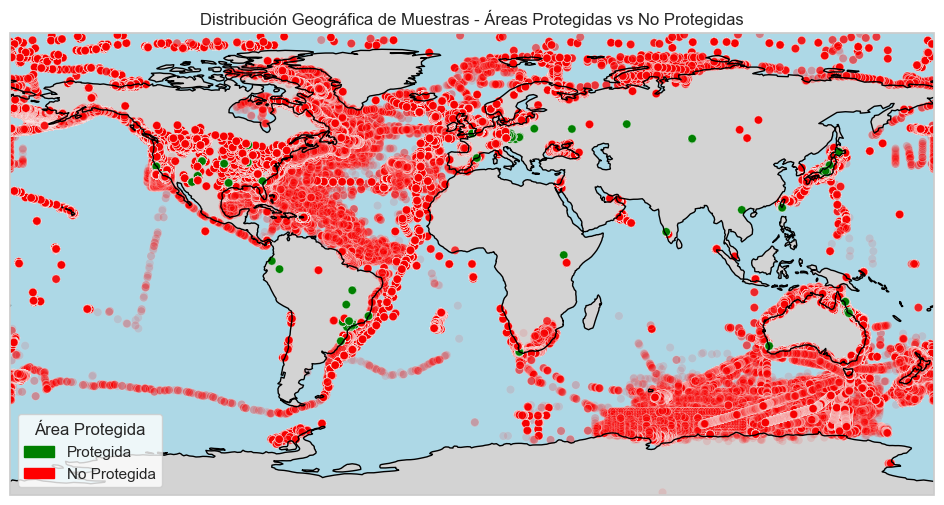

In [208]:
import matplotlib.patches as mpatches

merged_data = samples.merge(studies[['STUDY_ID', 'PROTECTED_AREA']], on='STUDY_ID', how='left')
merged_data['PROTECTED_AREA'] = merged_data['PROTECTED_AREA'].astype(str)
plt.figure(figsize=(9, 6))

# Crear la figura y los ejes con proyección geográfica
fig, ax = plt.subplots(figsize=(12, 6), subplot_kw={'projection': ccrs.PlateCarree()})

# Agregar el mapa base (costas, fronteras, océanos, etc.)
ax.add_feature(cfeature.LAND, facecolor='lightgray')
ax.add_feature(cfeature.OCEAN, facecolor='lightblue')
ax.add_feature(cfeature.COASTLINE, edgecolor='black')

sns.scatterplot(
    data=merged_data, 
    x="LONGITUDE", 
    y="LATITUDE", 
    hue="PROTECTED_AREA", 
    palette={"True": "green", "False": "red"}, 
    alpha=0.1,
    legend=False,
    transform=ccrs.PlateCarree(),
    ax=ax
)

legend_labels = [
    mpatches.Patch(color="green", label="Protegida"),
    mpatches.Patch(color="red", label="No Protegida")
]
plt.legend(handles=legend_labels, title="Área Protegida", loc="lower left")

plt.title("Distribución Geográfica de Muestras - Áreas Protegidas vs No Protegidas")
plt.xlabel("Longitud")
plt.ylabel("Latitud")
plt.show()

Veamos los países que más muestras tienen asociadas:

A continuación asociamos cada par de coordenadas (latitud y longitud) a un país realizando un cruce espacial con un shapefile (o dataset geográfico), para esto, utilizamos el dataset límites del mundo que provee GeoPandas

In [33]:
shapefile_path = "./world/ne_10m_admin_0_countries.shp"
world = gpd.read_file(shapefile_path)

Ahora, para asociar las muestras a los países, creamos una columna `geometry` a partir de LONGITUDE y LATITUDE para las muestras

In [34]:
geometry_samples = [Point(xy) for xy in zip(samples_cleaned['LONGITUDE'], samples_cleaned['LATITUDE'])]
gdf_samples = gpd.GeoDataFrame(samples_cleaned, geometry=geometry_samples)
gdf_samples.crs = "EPSG:4326"  # Sistema de coordenadas geográficas

Realizamos un spatial join para asignar el país a cada muestra:

In [35]:
samples_with_country = gpd.sjoin(gdf_samples, world, how="left", predicate="within")

Mostramos algunas filas para comprobar la asignación del país (la columna 'NAME' o similar dependerá del shapefile)

In [36]:
samples_with_country[['LONGITUDE', 'LATITUDE', 'sum.allrawdata.ABUNDANCE', 'NAME']].head()

LONGITUDE  LATITUDE  sum.allrawdata.ABUNDANCE                      NAME
0     -95.12      47.4                       1.0  United States of America
1     -95.12      47.4                       3.0  United States of America
2     -95.12      47.4                       1.0  United States of America
3     -95.12      47.4                      12.0  United States of America
4     -95.12      47.4                       1.0  United States of America

Calculamos el número de muestras por país y graficamos:

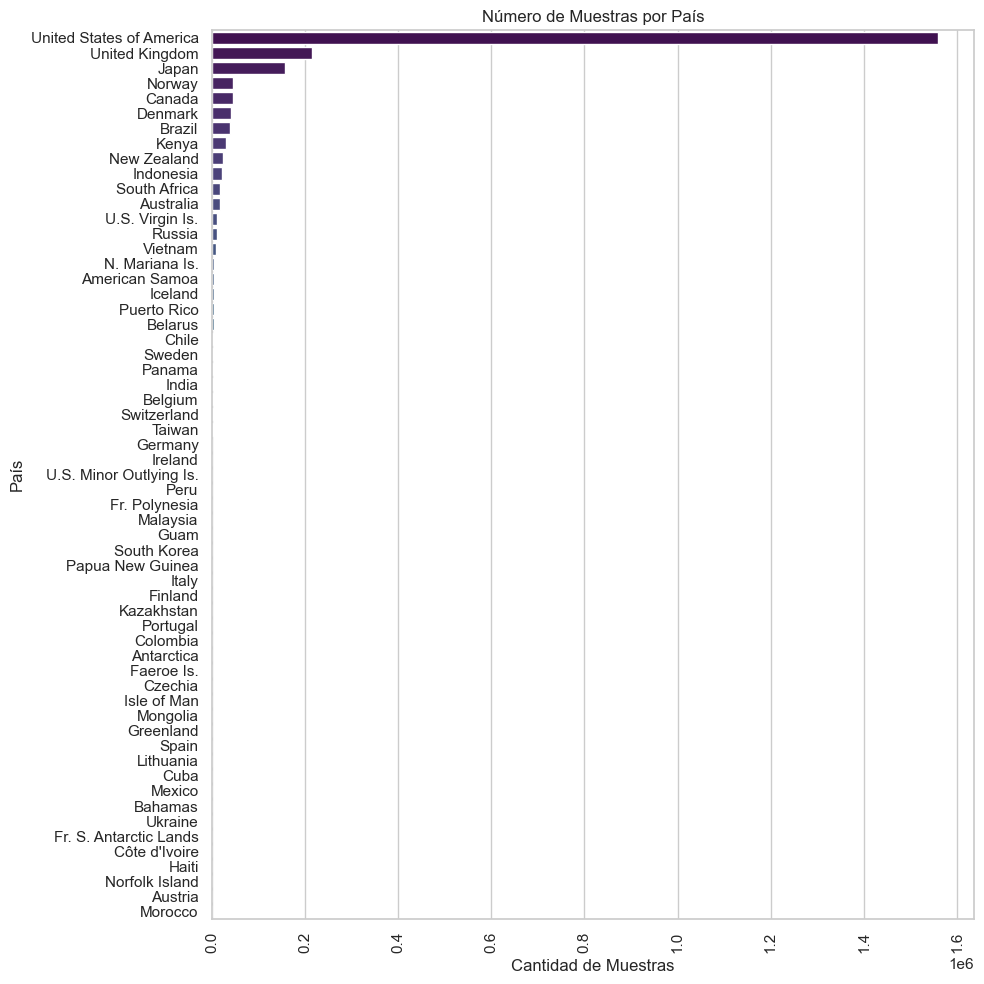

In [37]:
samples_by_country = samples_with_country.groupby('NAME').size().reset_index(name='counts')
samples_by_country.sort_values('counts', ascending=False, inplace=True)
# Gráfica: Número de muestras por país
plt.figure(figsize=(10, 10))
sns.barplot(data=samples_by_country, x='counts', y='NAME', palette="viridis", hue='NAME')
plt.xticks(rotation=90)
plt.title("Número de Muestras por País")
plt.xlabel("Cantidad de Muestras")
plt.ylabel("País")
plt.tight_layout()
plt.show()

Para facilitar la visualización, graficamos en escala logarítmica:

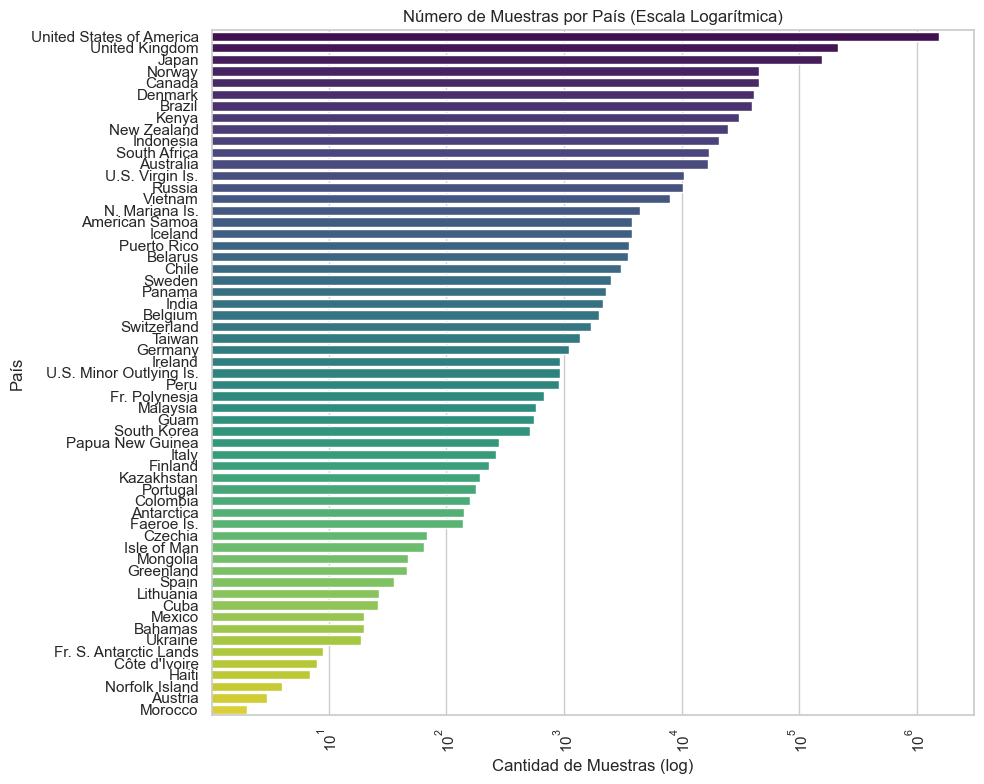

In [38]:
# Gráfica: Número de muestras por país (log)
plt.figure(figsize=(10, 8))
sns.barplot(data=samples_by_country, x='counts', y='NAME', palette="viridis", hue='NAME')
plt.xscale("log")  # Aplicar escala logarítmica
plt.xticks(rotation=90)
plt.title("Número de Muestras por País (Escala Logarítmica)")
plt.xlabel("Cantidad de Muestras (log)")
plt.ylabel("País")
plt.tight_layout()
plt.show()

## Análisis centrado en Estados Unidos

Filtramos los registros de samples que están ubicados en Estados Unidos y guardamos las variables que más nos interesan:

In [39]:
samples_usa = samples_with_country.loc[samples_with_country["NAME"] == "United States of America"]
samples_usa = samples_usa[['STUDY_ID', "NAME", 'YEAR', 'ID_SPECIES', 'LATITUDE', 'LONGITUDE',
       'sum.allrawdata.ABUNDANCE', 'sum.allrawdata.BIOMASS', 'GENUS',
       'GENUS_SPECIES']]

Guardamos los correspondientes estudios de las muestras filtradas:

In [40]:
studies_usa = studies_cleaned[studies_cleaned['STUDY_ID'].isin(samples_usa['STUDY_ID'])]

### Variables categóricas

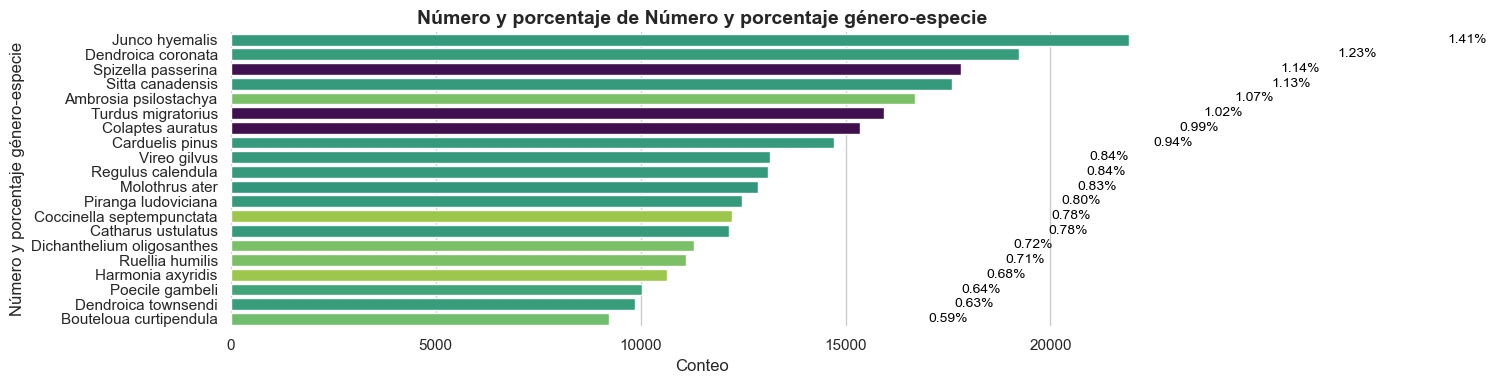

In [41]:
plot_count("GENUS_SPECIES", "Número y porcentaje género-especie", samples_usa, 4)

In [74]:
# Contamos cuántos valores únicos tiene la variable "GENUS_SPECIES" en samples_usa
unique_genus_species_count = studies_usa['TAXA'].nunique()
print(f"Número de valores únicos en GENUS_SPECIES: {unique_genus_species_count}")



Número de valores únicos en GENUS_SPECIES: 13


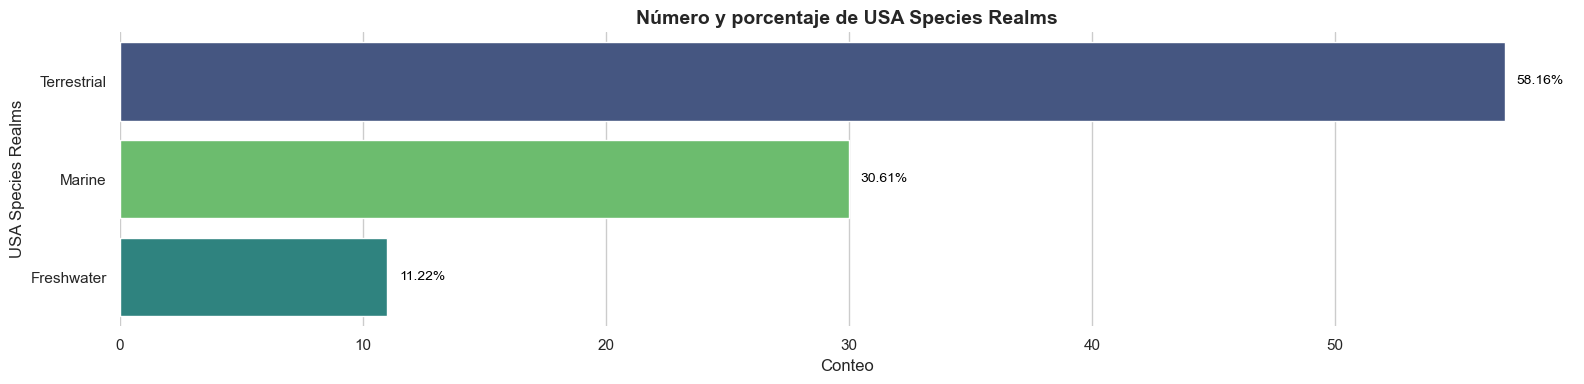

In [68]:
plot_count("REALM", "USA Species Realms", studies_usa, 4)

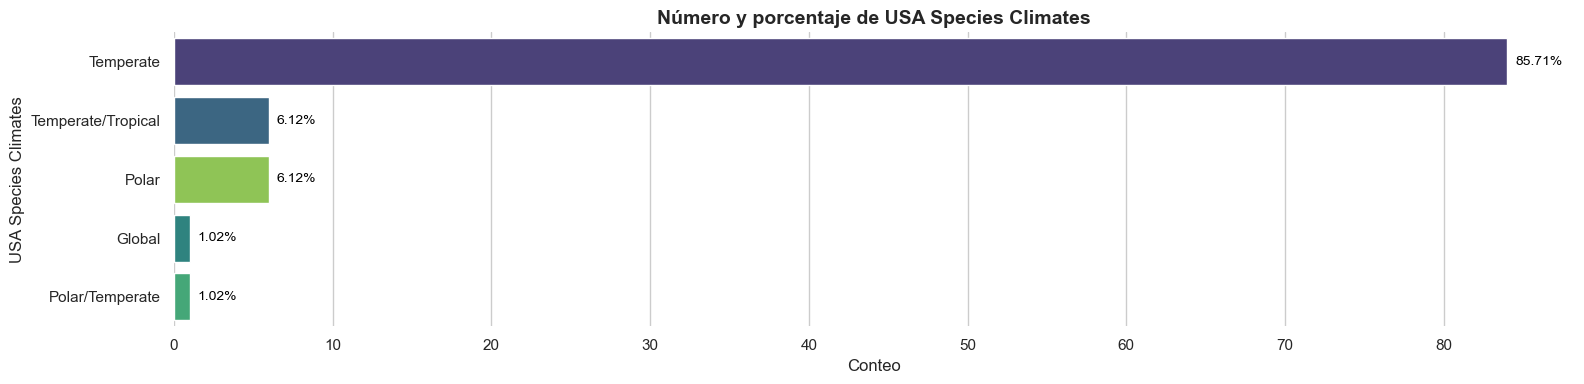

In [65]:
plot_count("CLIMATE", "USA Species Climates", studies_usa,4)

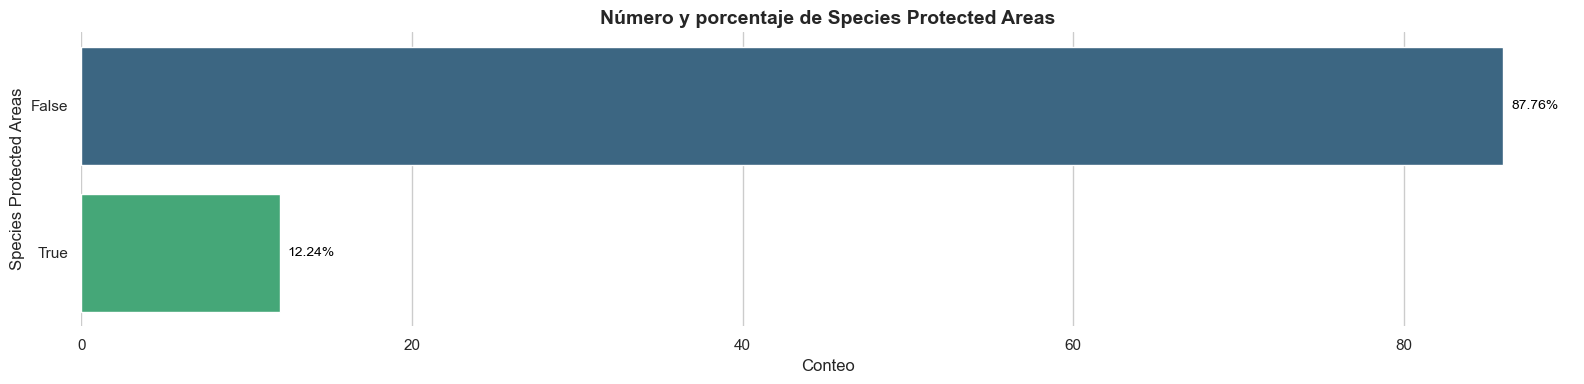

In [53]:
plot_count("PROTECTED_AREA", "Species Protected Areas", studies_usa,4)

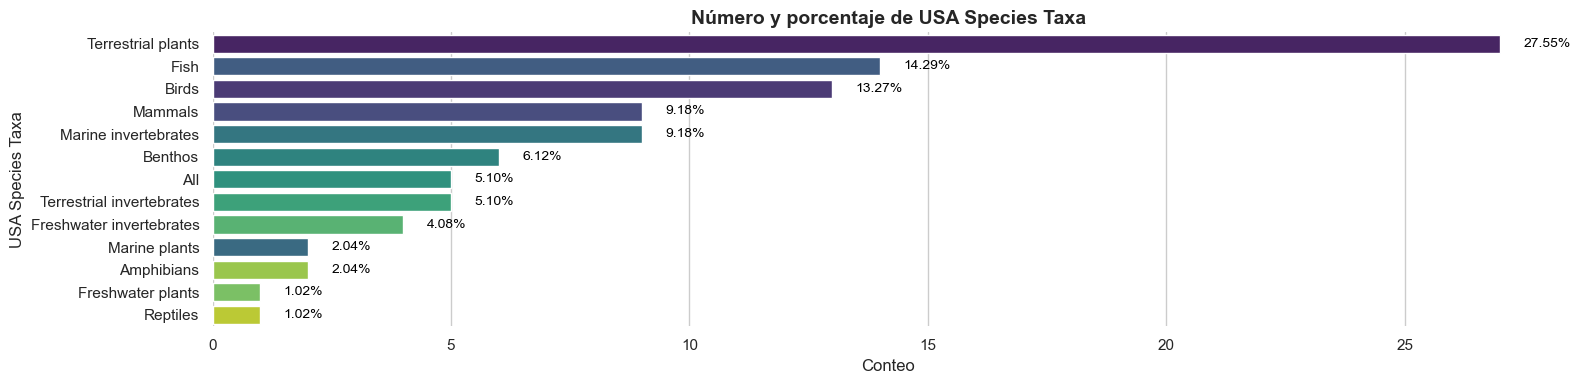

In [69]:
plot_count("TAXA", "USA Species Taxa", studies_usa,4)

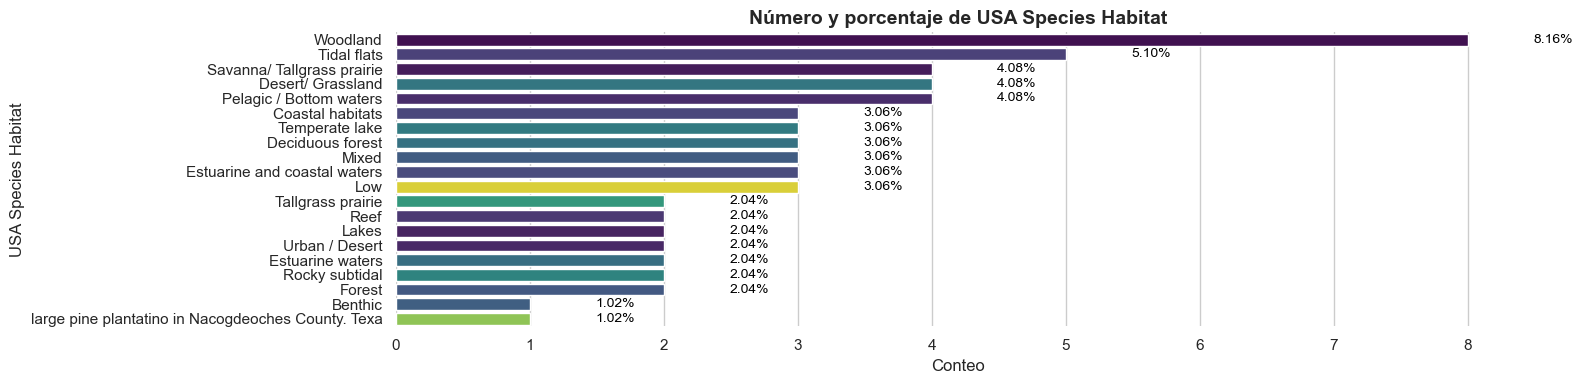

In [64]:
plot_count("HABITAT", "USA Species Habitat", studies_usa,4)

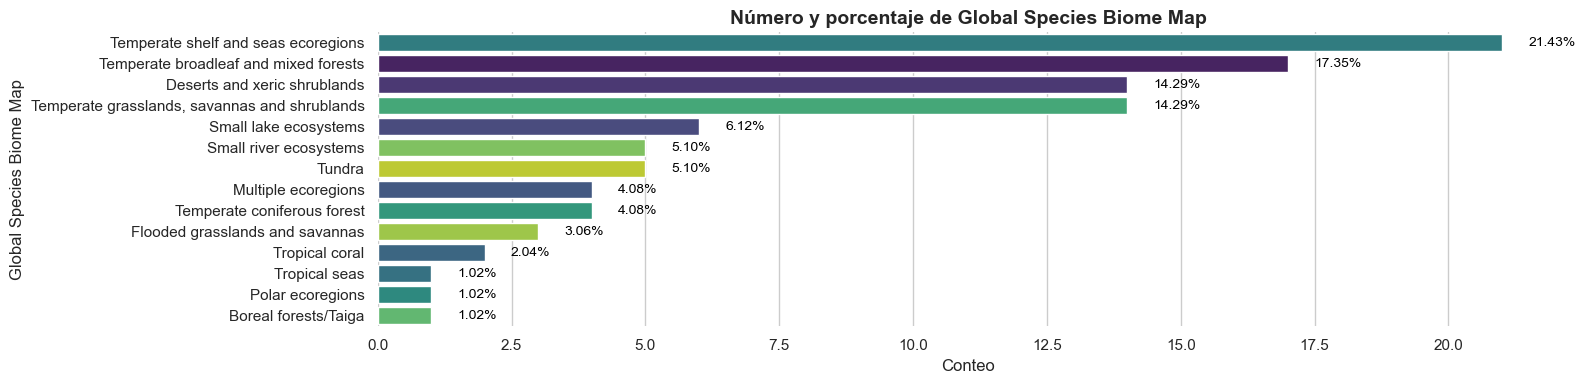

In [49]:
plot_count("BIOME_MAP", "Global Species Biome Map", studies_usa,4)

### Análisis geoespacial

Veamos algunas de las gráficas geoespaciales:

Text(0.5, 1.0, 'Distribución Geográfica de Muestras - Abundancia')

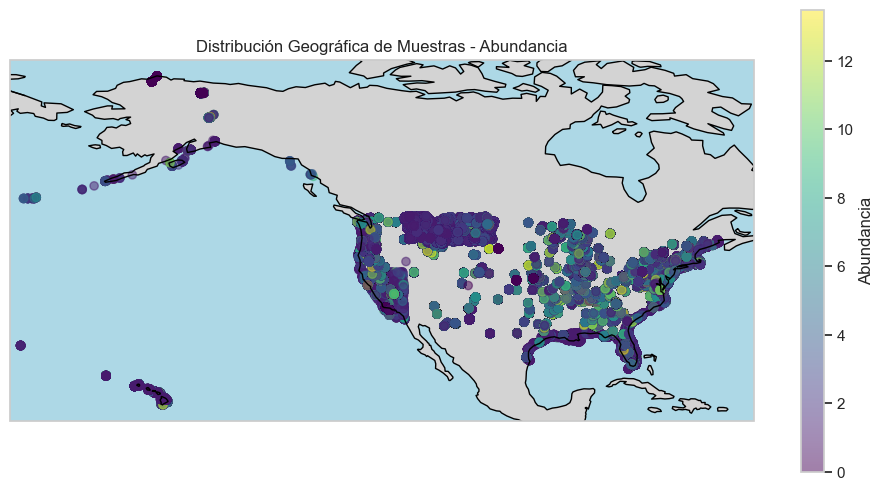

In [210]:
# Crear la figura y los ejes con proyección geográfica
fig, ax = plt.subplots(figsize=(12, 6), subplot_kw={'projection': ccrs.PlateCarree()})

# Agregar el mapa base (costas, fronteras, océanos, etc.)
ax.add_feature(cfeature.LAND, facecolor='lightgray')
ax.add_feature(cfeature.OCEAN, facecolor='lightblue')
ax.add_feature(cfeature.COASTLINE, edgecolor='black')

# Graficar los puntos de abundancia
scatter = ax.scatter(
    samples_usa['LONGITUDE'], samples_usa['LATITUDE'], 
    c=samples_usa['sum.allrawdata.ABUNDANCE'], 
    cmap='viridis', alpha=0.5, transform=ccrs.PlateCarree()
)

# Agregar barra de color y etiquetas
plt.colorbar(scatter, label='Abundancia')
ax.set_title("Distribución Geográfica de Muestras - Abundancia")

Text(0.5, 1.0, 'Distribución Geográfica de Muestras - Biomasa')

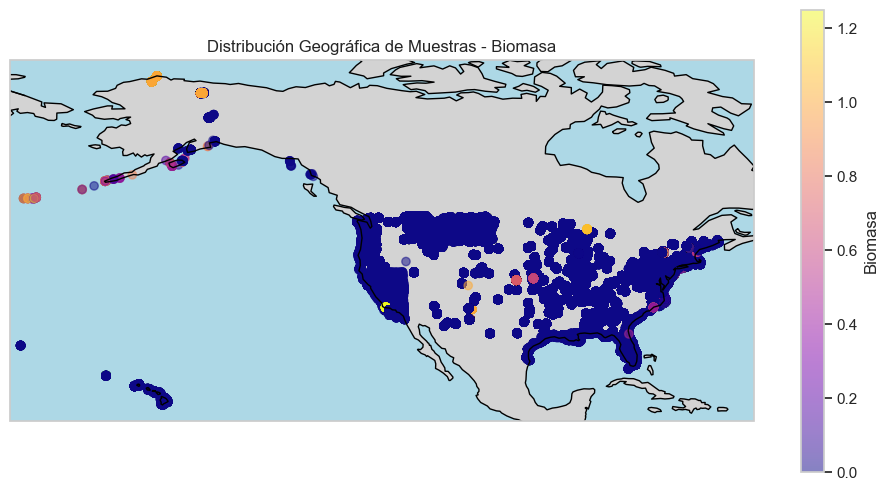

In [211]:
# Crear la figura y los ejes con proyección geográfica
fig, ax = plt.subplots(figsize=(12, 6), subplot_kw={'projection': ccrs.PlateCarree()})

# Agregar el mapa base (costas, fronteras, océanos, etc.)
ax.add_feature(cfeature.LAND, facecolor='lightgray')
ax.add_feature(cfeature.OCEAN, facecolor='lightblue')
ax.add_feature(cfeature.COASTLINE, edgecolor='black')

# Graficar los puntos de abundancia
scatter = ax.scatter(
    samples_usa['LONGITUDE'], samples_usa['LATITUDE'], 
    c=samples_usa['sum.allrawdata.BIOMASS'], 
    cmap='plasma', alpha=0.5, transform=ccrs.PlateCarree()
)

# Agregar barra de color y etiquetas
plt.colorbar(scatter, label='Biomasa')
ax.set_title("Distribución Geográfica de Muestras - Biomasa")



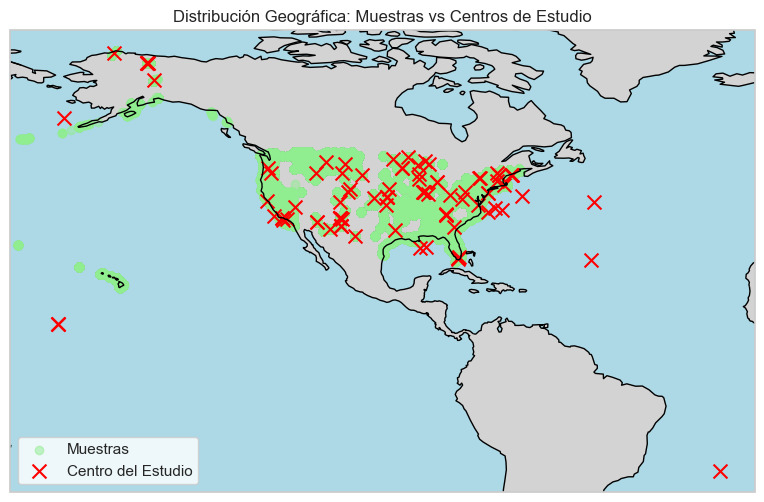

In [212]:
# Crear la figura y los ejes con proyección geográfica
fig, ax = plt.subplots(figsize=(12, 6), subplot_kw={'projection': ccrs.PlateCarree()})

# Agregar el mapa base (costas, fronteras, océanos, etc.)
ax.add_feature(cfeature.LAND, facecolor='lightgray')
ax.add_feature(cfeature.OCEAN, facecolor='lightblue')
ax.add_feature(cfeature.COASTLINE, edgecolor='black')

# Comparación espacial: Muestras vs Centros de Estudio
ax.scatter(
  samples_usa['LONGITUDE'], samples_usa['LATITUDE'],
  c='lightgreen', alpha=0.5, label='Muestras', transform=ccrs.PlateCarree()
)
ax.scatter(
  studies_usa['CENT_LONG'], studies_usa['CENT_LAT'],
  c='red', marker='x', s=100, label='Centro del Estudio', 
  transform=ccrs.PlateCarree()
)
plt.title('Distribución Geográfica: Muestras vs Centros de Estudio')
plt.xlabel('Longitud')
plt.ylabel('Latitud')
plt.legend(loc='lower left')
plt.show()

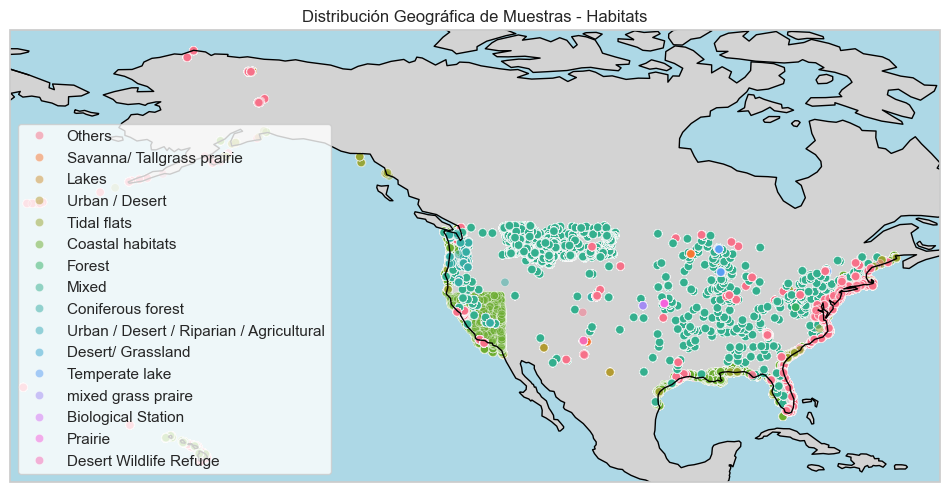

In [57]:
import matplotlib.patches as mpatches

merged_data = samples_usa.merge(studies_usa[['STUDY_ID', 'HABITAT']], on='STUDY_ID', how='left')
merged_data['HABITAT'] = merged_data['HABITAT'].astype(str)

top_10_habitats = merged_data['HABITAT'].value_counts().nlargest(15).index
merged_data['HABITAT_TOP10'] = merged_data['HABITAT'].where(
    merged_data['HABITAT'].isin(top_10_habitats), 
    'Others'
)

# Crear la figura y los ejes con proyección geográfica
fig, ax = plt.subplots(figsize=(12, 6), subplot_kw={'projection': ccrs.PlateCarree()})
# Agregar el mapa base (costas, fronteras, océanos, etc.)
ax.add_feature(cfeature.LAND, facecolor='lightgray')
ax.add_feature(cfeature.OCEAN, facecolor='lightblue')
ax.add_feature(cfeature.COASTLINE, edgecolor='black')

sns.scatterplot(
    data=merged_data, 
    x="LONGITUDE", 
    y="LATITUDE", 
    hue="HABITAT_TOP10", 
    alpha=0.5,
    legend=True,
    transform=ccrs.PlateCarree(),
    ax=ax
)


plt.legend(loc='lower left')
plt.title("Distribución Geográfica de Muestras - Habitats")
plt.xlabel("Longitud")
plt.ylabel("Latitud")
plt.show()

<Figure size 900x600 with 0 Axes>

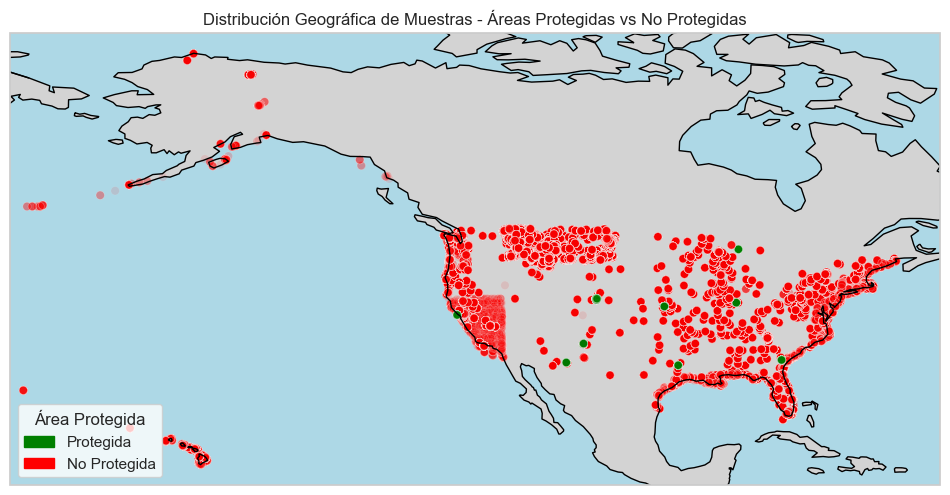

In [209]:
import matplotlib.patches as mpatches

merged_data = samples_usa.merge(studies_usa[['STUDY_ID', 'PROTECTED_AREA']], on='STUDY_ID', how='left')
merged_data['PROTECTED_AREA'] = merged_data['PROTECTED_AREA'].astype(str)
plt.figure(figsize=(9, 6))

# Crear la figura y los ejes con proyección geográfica
fig, ax = plt.subplots(figsize=(12, 6), subplot_kw={'projection': ccrs.PlateCarree()})

# Agregar el mapa base (costas, fronteras, océanos, etc.)
ax.add_feature(cfeature.LAND, facecolor='lightgray')
ax.add_feature(cfeature.OCEAN, facecolor='lightblue')
ax.add_feature(cfeature.COASTLINE, edgecolor='black')

sns.scatterplot(
    data=merged_data, 
    x="LONGITUDE", 
    y="LATITUDE", 
    hue="PROTECTED_AREA", 
    palette={"True": "green", "False": "red"}, 
    alpha=0.1,
    legend=False,
    transform=ccrs.PlateCarree(),
    ax=ax
)

legend_labels = [
    mpatches.Patch(color="green", label="Protegida"),
    mpatches.Patch(color="red", label="No Protegida")
]
plt.legend(handles=legend_labels, title="Área Protegida", loc="lower left")

plt.title("Distribución Geográfica de Muestras - Áreas Protegidas vs No Protegidas")
plt.xlabel("Longitud")
plt.ylabel("Latitud")
plt.show()

<Figure size 900x600 with 0 Axes>

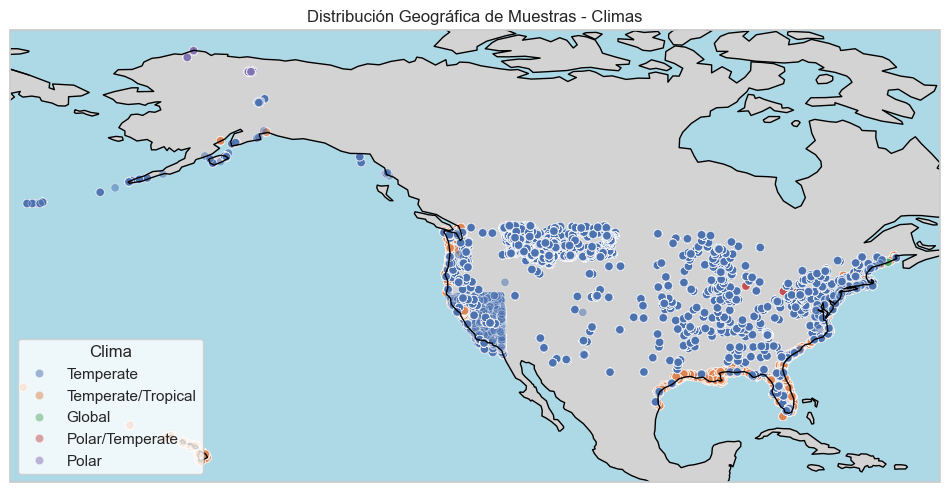

In [62]:
import matplotlib.patches as mpatches

merged_data = samples_usa.merge(studies_usa[['STUDY_ID', 'CLIMATE']], on='STUDY_ID', how='left')
merged_data['CLIMATE'] = merged_data['CLIMATE'].astype(str)
plt.figure(figsize=(9, 6))

# Crear la figura y los ejes con proyección geográfica
fig, ax = plt.subplots(figsize=(12, 6), subplot_kw={'projection': ccrs.PlateCarree()})

# Agregar el mapa base (costas, fronteras, océanos, etc.)
ax.add_feature(cfeature.LAND, facecolor='lightgray')
ax.add_feature(cfeature.OCEAN, facecolor='lightblue')
ax.add_feature(cfeature.COASTLINE, edgecolor='black')

sns.scatterplot(
    data=merged_data, 
    x="LONGITUDE", 
    y="LATITUDE", 
    hue="CLIMATE", 
    alpha=0.5,
    legend=True,
    transform=ccrs.PlateCarree(),
    ax=ax
)

plt.legend(title="Clima", loc="lower left")

plt.title("Distribución Geográfica de Muestras - Climas")
plt.xlabel("Longitud")
plt.ylabel("Latitud")
plt.show()

<Figure size 900x600 with 0 Axes>

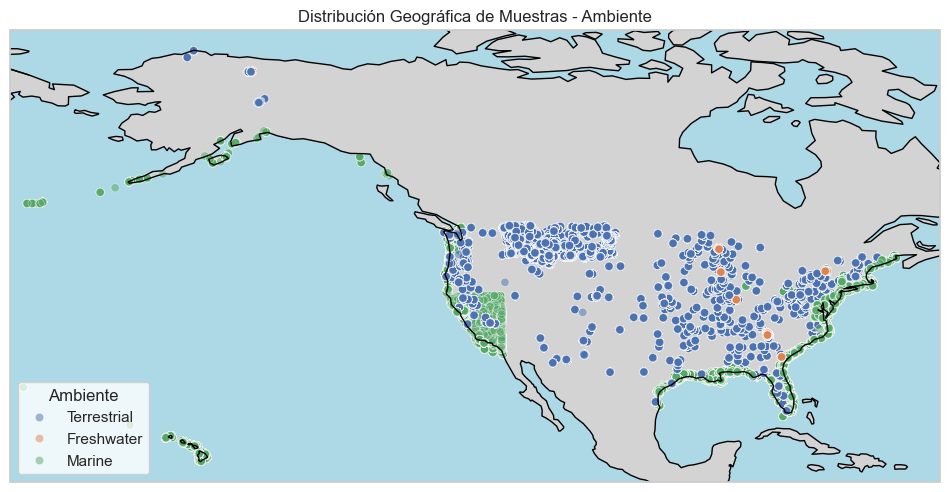

In [67]:
import matplotlib.patches as mpatches
merged_data = samples_usa.merge(studies_usa[['STUDY_ID', 'REALM']], on='STUDY_ID', how='left')
merged_data['CLIMATE'] = merged_data['REALM'].astype(str)
plt.figure(figsize=(9, 6))

# Crear la figura y los ejes con proyección geográfica
fig, ax = plt.subplots(figsize=(12, 6), subplot_kw={'projection': ccrs.PlateCarree()})

# Agregar el mapa base (costas, fronteras, océanos, etc.)
ax.add_feature(cfeature.LAND, facecolor='lightgray')
ax.add_feature(cfeature.OCEAN, facecolor='lightblue')
ax.add_feature(cfeature.COASTLINE, edgecolor='black')

sns.scatterplot(
    data=merged_data, 
    x="LONGITUDE", 
    y="LATITUDE", 
    hue="REALM", 
    alpha=0.5,
    legend=True,
    transform=ccrs.PlateCarree(),
    ax=ax
)

plt.legend(title="Ambiente", loc="lower left")

plt.title("Distribución Geográfica de Muestras - Ambiente")
plt.xlabel("Longitud")
plt.ylabel("Latitud")
plt.show()

<Figure size 900x600 with 0 Axes>

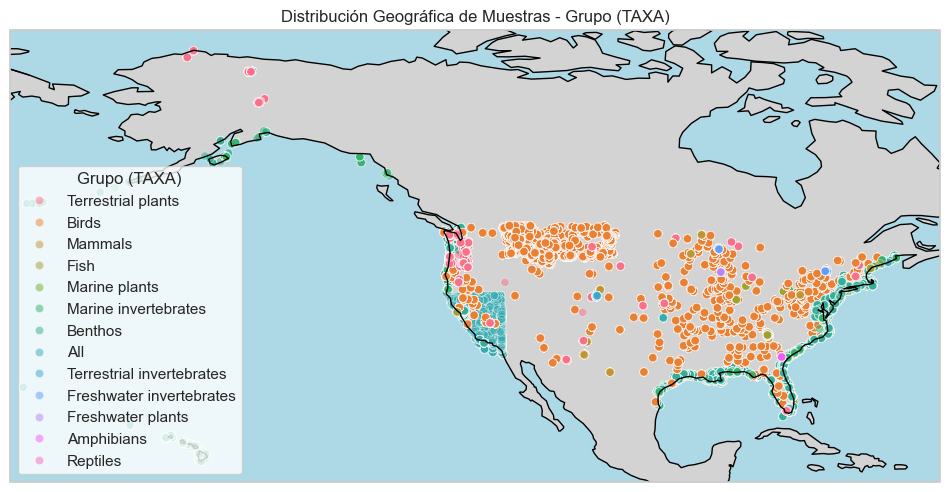

In [72]:
import matplotlib.patches as mpatches
merged_data = samples_usa.merge(studies_usa[['STUDY_ID', 'TAXA']], on='STUDY_ID', how='left')
merged_data['CLIMATE'] = merged_data['TAXA'].astype(str)
plt.figure(figsize=(9, 6))

# Crear la figura y los ejes con proyección geográfica
fig, ax = plt.subplots(figsize=(12, 6), subplot_kw={'projection': ccrs.PlateCarree()})

# Agregar el mapa base (costas, fronteras, océanos, etc.)
ax.add_feature(cfeature.LAND, facecolor='lightgray')
ax.add_feature(cfeature.OCEAN, facecolor='lightblue')
ax.add_feature(cfeature.COASTLINE, edgecolor='black')

sns.scatterplot(
    data=merged_data, 
    x="LONGITUDE", 
    y="LATITUDE", 
    hue="TAXA", 
    alpha=0.5,
    legend=True,
    transform=ccrs.PlateCarree(),
    ax=ax
)

plt.legend(title="Grupo (TAXA)", loc="lower left")

plt.title("Distribución Geográfica de Muestras - Grupo (TAXA)")
plt.xlabel("Longitud")
plt.ylabel("Latitud")
plt.show()

### Combinando los datasets

Para combinar los datasets, podemos hacer un inner join usando la variable `STUDY_ID`:

In [72]:
merged_df = studies_usa.merge(samples_usa, on='STUDY_ID', how='inner')

Podemos ver cómo ha crecido el número de muestras asociadas a un clima templado/caliente para tener un "indicio" de los efectos del cambio climático:

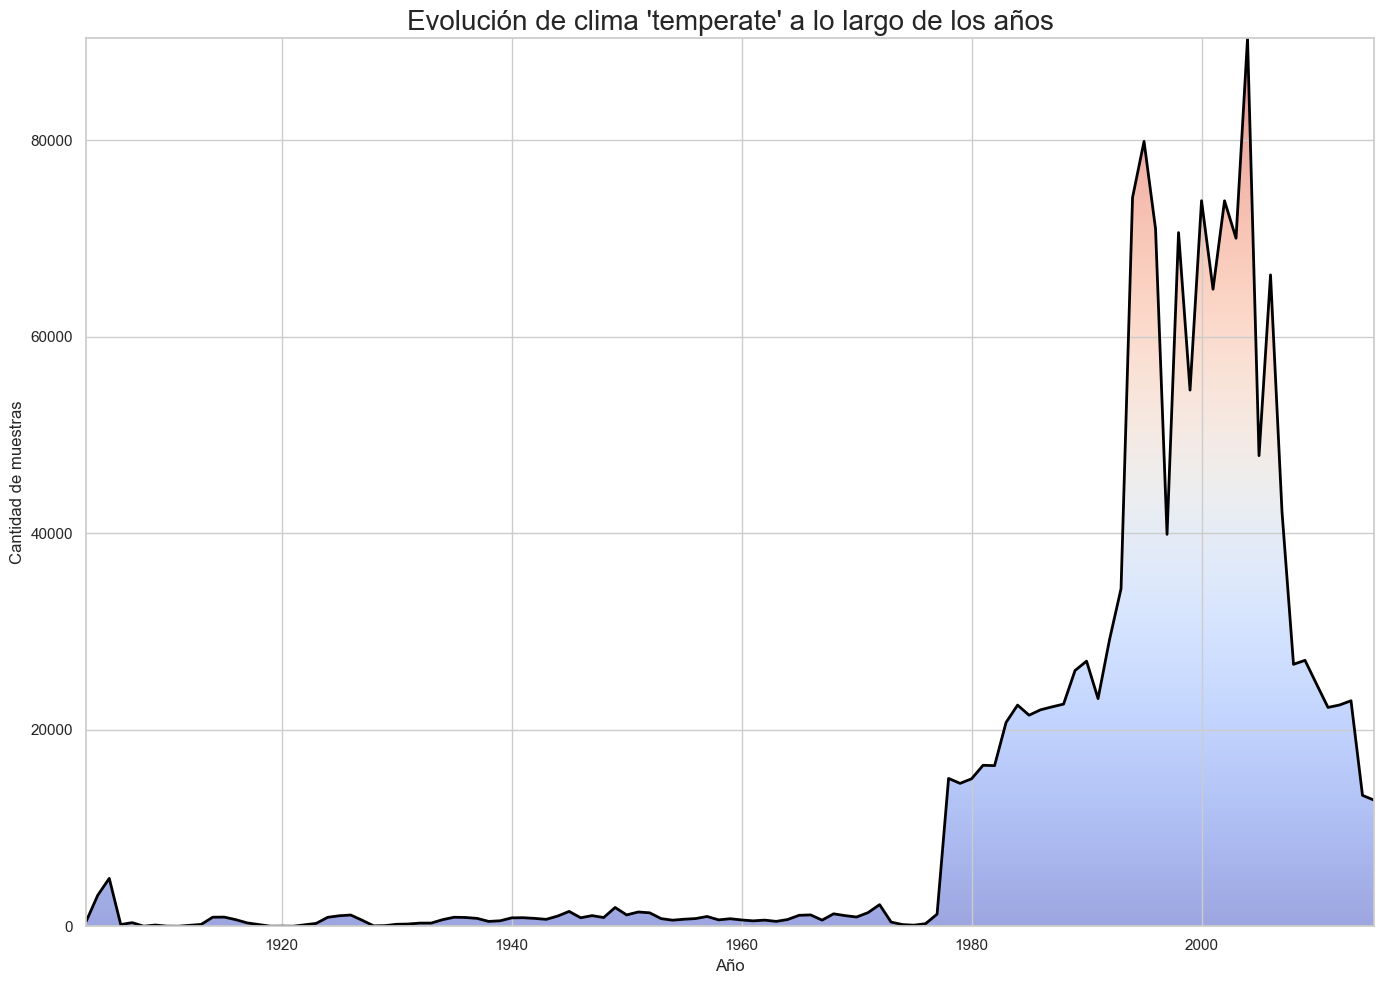

In [98]:
import matplotlib.colors as mcolors
from matplotlib.patches import Polygon

# Filtrar estudios con clima "temperate"
temperate_data = merged_df[merged_df['CLIMATE'] == 'Temperate']

# Agrupar por año de inicio y contar la cantidad de estudios
counts = temperate_data.groupby('YEAR').size()

# Extraer los valores del eje x (años) y y (conteo de muestras)
x = counts.index.values
y = counts.values

fig, ax = plt.subplots(figsize=(14, 10))

ax.plot(x, y, color='black', linewidth=2)
gradient = np.linspace(0, 1, 256).reshape(256, 1)[::-1]
cmap = plt.get_cmap("coolwarm")

# Mostramos la imagen en el eje. Ajustamos el 'extent' para que cubra el rango en x y desde 0 hasta el máximo en y.
im = ax.imshow(
  gradient,
  extent=[x.min(), x.max(), 0, y.max()],
  aspect='auto',
  cmap=cmap,
  alpha=0.5
)

verts = [(x[0], 0)] + list(zip(x, y)) + [(x[-1], 0)]
poly = Polygon(verts, facecolor='none', edgecolor='none', closed=True)
ax.add_patch(poly)

im.set_clip_path(poly)

ax.set_title("Evolución de clima 'temperate' a lo largo de los años", fontsize=20)
ax.set_xlabel("Año")
ax.set_ylabel("Cantidad de muestras")
plt.tight_layout()
plt.show()


### Planteamiento de modelos

Mediante la matriz de correlaciones podemos pensar en la formulación de algún modelo predictorio:

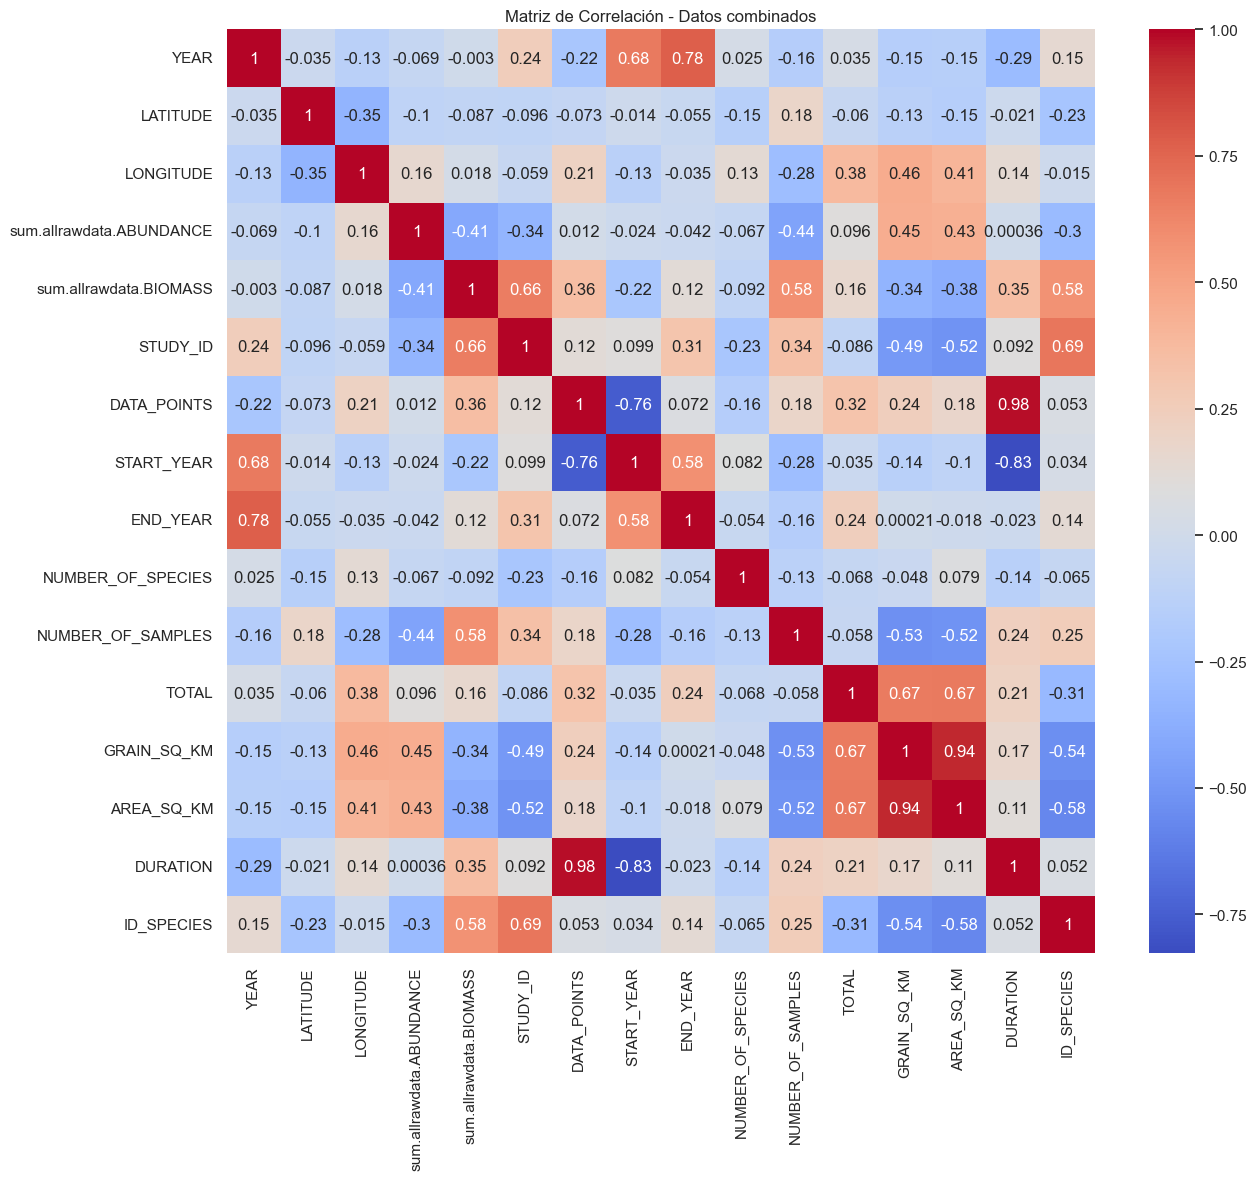

In [84]:
merged_df['DURATION'] = merged_df['END_YEAR'] - merged_df['START_YEAR']
numeric_cols = ['YEAR', 'LATITUDE', 'LONGITUDE', 
                'sum.allrawdata.ABUNDANCE', 'sum.allrawdata.BIOMASS', 'STUDY_ID', 'DATA_POINTS', 'START_YEAR', 'END_YEAR', 
                'NUMBER_OF_SPECIES', 'NUMBER_OF_SAMPLES', 'TOTAL', 
                'GRAIN_SQ_KM', 'AREA_SQ_KM', 'DURATION', 'ID_SPECIES']
# Matriz de correlación para variables numéricas
corr = merged_df[numeric_cols].corr()
plt.figure(figsize=(14, 12))
sns.heatmap(corr, annot=True, cmap="coolwarm")
plt.title("Matriz de Correlación - Datos combinados")
plt.show()

#### Modelo 1

Consideraremos las variables `sum.allrawdata.BIOMASS`, `DATA_POINTS`, `LONGITUDE` y `AREA_SQ_KM` para predecir la variable `sum.allrawdata.ABUNDANCE`.

In [192]:
from sklearn.model_selection import train_test_split

# Supongamos que df es tu dataframe
data = merged_df[merged_df['sum.allrawdata.ABUNDANCE'] != 0]
data = merged_df[merged_df['sum.allrawdata.BIOMASS'] != 0]
X = data[["sum.allrawdata.BIOMASS", "DATA_POINTS", "LONGITUDE", "AREA_SQ_KM"]]  # Variables seleccionadas
y = data['sum.allrawdata.ABUNDANCE']  # Variable objetivo

X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)

MSE: 0.9815455804971024
R2: 0.18409414906589217


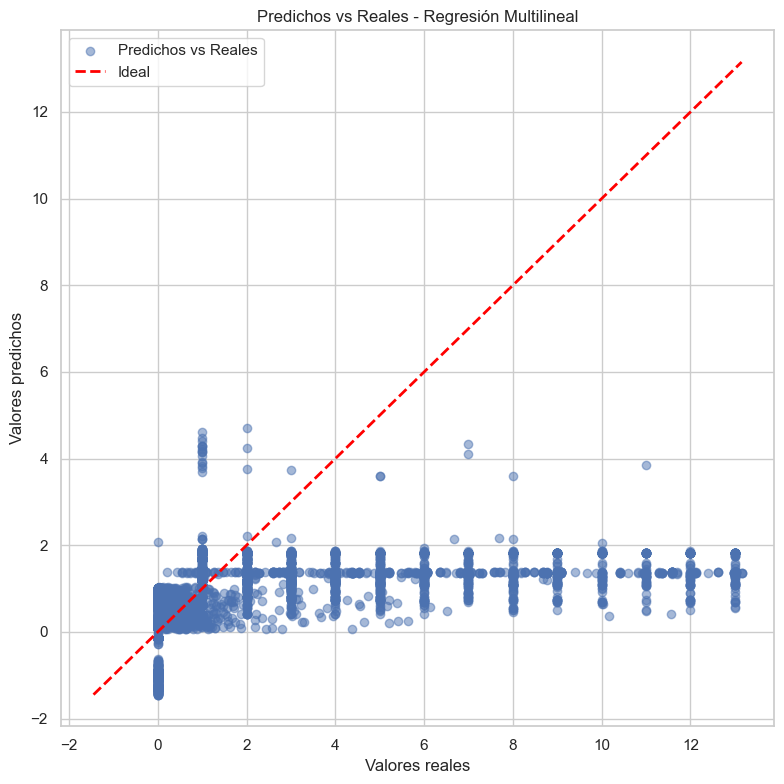

In [213]:
from sklearn.linear_model import LinearRegression
from sklearn.metrics import mean_squared_error, r2_score

# ---------------------------
# Regresión Multilineal
# ---------------------------
model = LinearRegression()
model.fit(X_train, y_train)

y_pred = model.predict(X_test)

mse = mean_squared_error(y_test, y_pred)
r2 = r2_score(y_test, y_pred)

print("MSE:", mse)
print("R2:", r2)

# Crear la figura
plt.figure(figsize=(8, 8))

# Graficar los puntos: valores reales en x, predichos en y
plt.scatter(y_test, y_pred, alpha=0.5, label='Predichos vs Reales')

# Agregar línea diagonal (ideal: predicho = real)
min_val = min(y_test.min(), y_pred.min())
max_val = max(y_test.max(), y_pred.max())
plt.plot([min_val, max_val], [min_val, max_val], color='red', linestyle='--', lw=2, label='Ideal')

# Etiquetas y título
plt.xlabel("Valores reales")
plt.ylabel("Valores predichos")
plt.title("Predichos vs Reales - Regresión Multilineal")
plt.legend()
plt.tight_layout()
plt.show()

Árbol de Decisión:
MSE: 0.36271999475778904
R2: 0.6984904503122638

Random Forest:
MSE: 0.32185121958943064
R2: 0.73246245675081


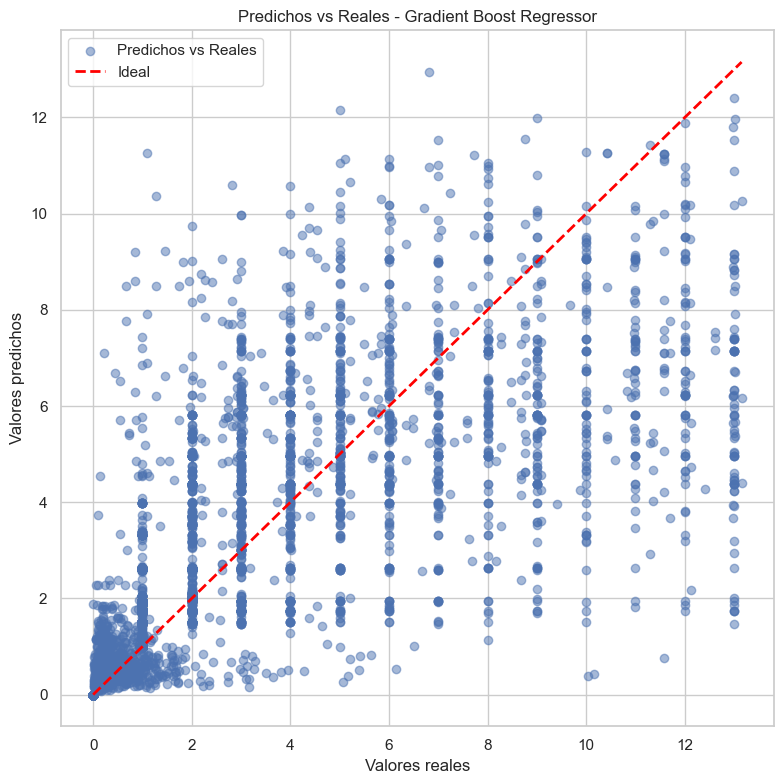

In [165]:
from sklearn.model_selection import train_test_split
from sklearn.tree import DecisionTreeRegressor
from sklearn.ensemble import RandomForestRegressor
from sklearn.metrics import mean_squared_error, r2_score


# ---------------------------
# Árbol de Decisión
# ---------------------------
tree_model = DecisionTreeRegressor(random_state=42)
tree_model.fit(X_train, y_train)
y_pred_tree = tree_model.predict(X_test)

mse_tree = mean_squared_error(y_test, y_pred_tree)
r2_tree = r2_score(y_test, y_pred_tree)

print("Árbol de Decisión:")
print("MSE:", mse_tree)
print("R2:", r2_tree)

# ---------------------------
# Random Forest
# ---------------------------
rf_model = RandomForestRegressor(n_estimators=100, random_state=42)
rf_model.fit(X_train, y_train)
y_pred_rf = rf_model.predict(X_test)

mse_rf = mean_squared_error(y_test, y_pred_rf)
r2_rf = r2_score(y_test, y_pred_rf)

print("\nRandom Forest:")
print("MSE:", mse_rf)
print("R2:", r2_rf)

# Crear la figura
plt.figure(figsize=(8, 8))

# Graficar los puntos: valores reales en x, predichos en y
plt.scatter(y_test, y_pred_rf, alpha=0.5, label='Predichos vs Reales')

# Agregar línea diagonal (ideal: predicho = real)
min_val = min(y_test.min(), y_pred_rf.min())
max_val = max(y_test.max(), y_pred_rf.max())
plt.plot([min_val, max_val], [min_val, max_val], color='red', linestyle='--', lw=2, label='Ideal')

# Etiquetas y título
plt.xlabel("Valores reales")
plt.ylabel("Valores predichos")
plt.title("Predichos vs Reales - Gradient Boost Regressor")
plt.legend()
plt.tight_layout()
plt.show()


Gradient Boosting Regressor:
MSE: 0.35411369689224514
R2: 0.705644401104669


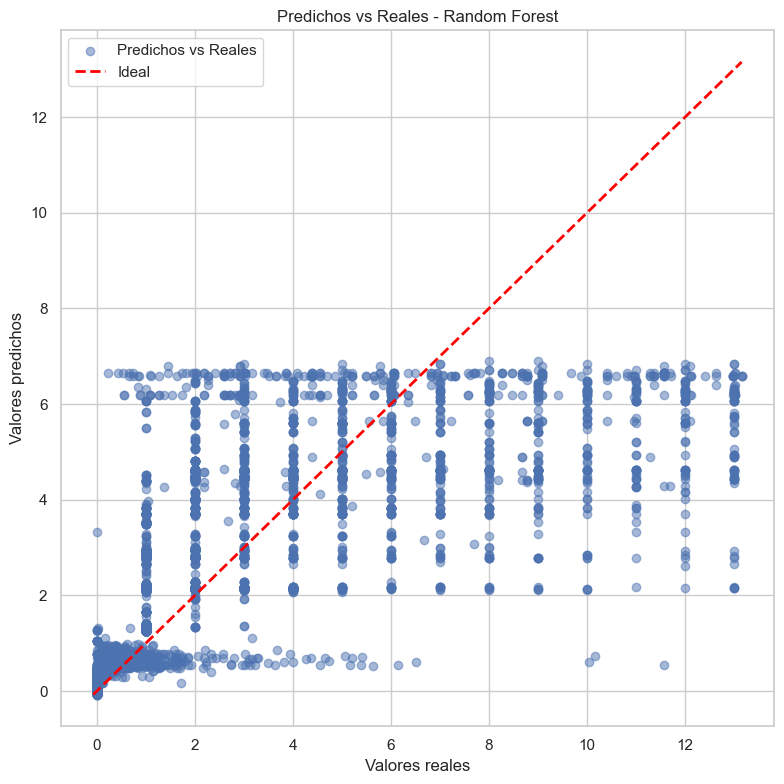

In [166]:
from sklearn.ensemble import GradientBoostingRegressor
from sklearn.metrics import mean_squared_error, r2_score

# Modelo de Boosting con GradientBoostingRegressor
gbr_model = GradientBoostingRegressor(random_state=42)
gbr_model.fit(X_train, y_train)
y_pred_gbr = gbr_model.predict(X_test)

mse_gbr = mean_squared_error(y_test, y_pred_gbr)
r2_gbr = r2_score(y_test, y_pred_gbr)

print("Gradient Boosting Regressor:")
print("MSE:", mse_gbr)
print("R2:", r2_gbr)

# Crear la figura
plt.figure(figsize=(8, 8))

# Graficar los puntos: valores reales en x, predichos en y
plt.scatter(y_test, y_pred_gbr, alpha=0.5, label='Predichos vs Reales')

# Agregar línea diagonal (ideal: predicho = real)
min_val = min(y_test.min(), y_pred_gbr.min())
max_val = max(y_test.max(), y_pred_gbr.max())
plt.plot([min_val, max_val], [min_val, max_val], color='red', linestyle='--', lw=2, label='Ideal')

# Etiquetas y título
plt.xlabel("Valores reales")
plt.ylabel("Valores predichos")
plt.title("Predichos vs Reales - Random Forest")
plt.legend()
plt.tight_layout()
plt.show()


XGBoost Regressor:
MSE: 0.3728032507114599
R2: 0.6901087839968801


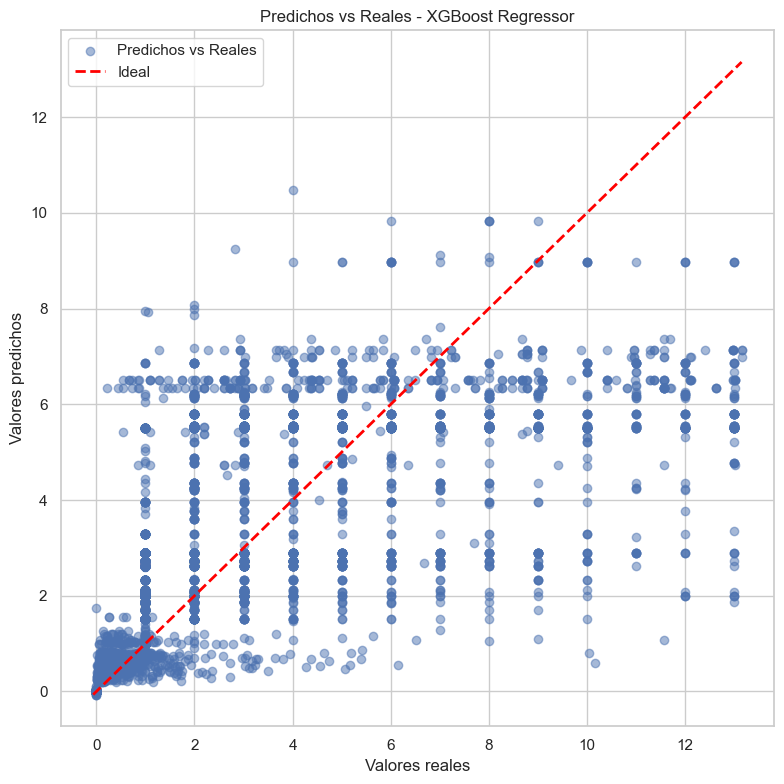

In [162]:
import xgboost as xgb

xgb_model = xgb.XGBRegressor(random_state=42)
xgb_model.fit(X_train, y_train)
y_pred_xgb = xgb_model.predict(X_test)

mse_xgb = mean_squared_error(y_test, y_pred_xgb)
r2_xgb = r2_score(y_test, y_pred_xgb)

print("\nXGBoost Regressor:")
print("MSE:", mse_xgb)
print("R2:", r2_xgb)

# Crear la figura
plt.figure(figsize=(8, 8))

# Graficar los puntos: valores reales en x, predichos en y
plt.scatter(y_test, y_pred_xgb, alpha=0.5, label='Predichos vs Reales')

# Agregar línea diagonal (ideal: predicho = real)
min_val = min(y_test.min(), y_pred_xgb.min())
max_val = max(y_test.max(), y_pred_xgb.max())
plt.plot([min_val, max_val], [min_val, max_val], color='red', linestyle='--', lw=2, label='Ideal')

# Etiquetas y título
plt.xlabel("Valores reales")
plt.ylabel("Valores predichos")
plt.title("Predichos vs Reales - XGBoost Regressor")
plt.legend()
plt.tight_layout()
plt.show()


#### Modelo 2

Tomaremos las variables `YEAR`, `LATITUDE`, `LONGITUDE`, `NUMBER_OF_SPECIES`, `AREA_SQ_KM`, `TAXA`, `REALM`, `CLIMATE` y `HABITAT` para predecir el logaritmo de la variable `sum.allrawdata.ABUNDANCE`.

In [214]:
import lightgbm as lgb
# Usamos 'sum.allrawdata.ABUNDANCE' para crear LOG_ABUNDANCE
merged_df['LOG_ABUNDANCE'] = np.log1p(merged_df['sum.allrawdata.ABUNDANCE'])

predictors = [
    'YEAR',
    'LATITUDE',
    'LONGITUDE',
    'NUMBER_OF_SPECIES',
    'AREA_SQ_KM',
    'TAXA',      # Categórica
    'REALM',     # Categórica
    'CLIMATE',   # Categórica
    'HABITAT'    # Categórica
]
X_raw = data[predictors]
y = data['LOG_ABUNDANCE']

# Convertir variables categóricas a dummies 
X = pd.get_dummies(X_raw, columns=['TAXA', 'REALM', 'CLIMATE', 'HABITAT'], drop_first=True)
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)

model = lgb.LGBMRegressor(n_estimators=100, max_depth=10, random_state=42)
model.fit(X_train, y_train)

# Evaluar el modelo 
y_pred_log = model.predict(X_test)
rmse_log = np.sqrt(mean_squared_error(y_test, y_pred_log))
print(f"RMSE en escala logarítmica: {rmse_log:.4f}")
print(f"R2 en escala logarítmica: {r2_score(y_test, y_pred_log):.4f}")

# Convertir las predicciones a la escala original: exp(pred) - 1
y_pred_orig = np.expm1(y_pred_log)
y_test_orig = np.expm1(y_test)
rmse_orig = np.sqrt(mean_squared_error(y_test_orig, y_pred_orig))
print(f"RMSE en escala original: {rmse_orig:.4f}")
print(f"R2 en escala original: {r2_score(y_test_orig, y_pred_orig):.4f}")

[LightGBM] [Warning] Found whitespace in feature_names, replace with underlines
[LightGBM] [Info] Auto-choosing row-wise multi-threading, the overhead of testing was 0.035998 seconds.
You can set `force_row_wise=true` to remove the overhead.
And if memory is not enough, you can set `force_col_wise=true`.
[LightGBM] [Info] Total Bins 322
[LightGBM] [Info] Number of data points in the train set: 299598, number of used features: 30
[LightGBM] [Info] Start training from score 0.071317
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best 

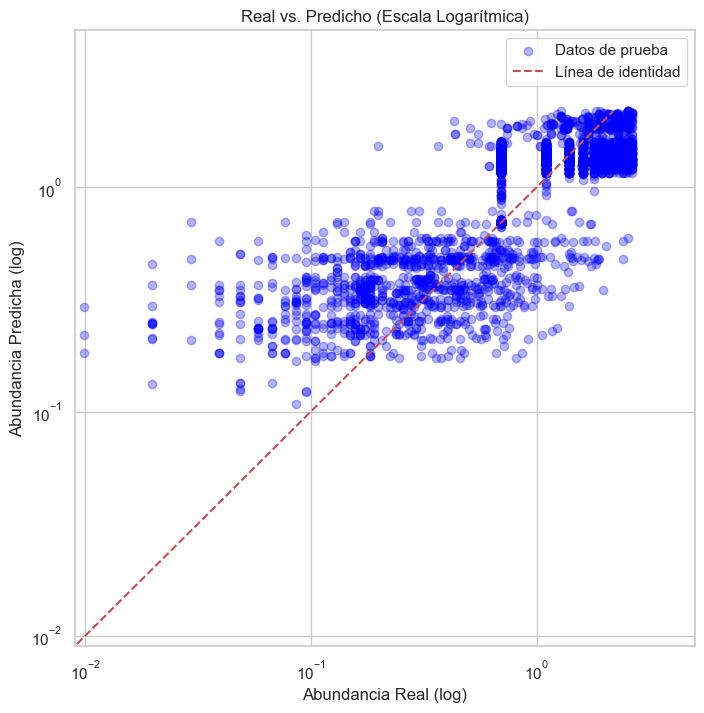

In [185]:
plt.figure(figsize=(8,8))
plt.xscale('log')
plt.yscale('log')
plt.scatter(y_test, y_pred_log, alpha=0.3, color='blue', label='Datos de prueba')
# Línea de identidad en log-log es la misma recta
min_val = min(y_pred_log[y_pred_log>0].min(), y_pred_log[y_pred_log>0].min())
max_val = max(y_pred_log.max(), y_pred_log.max())
plt.plot([min_val, max_val], [min_val, max_val], 'r--', label='Línea de identidad')
plt.xlim(0.009, 5)
plt.ylim(0.009, 5)
plt.xlabel("Abundancia Real (log)")
plt.ylabel("Abundancia Predicha (log)")
plt.title("Real vs. Predicho (Escala Logarítmica)")
plt.legend()
plt.grid(True)
plt.show()


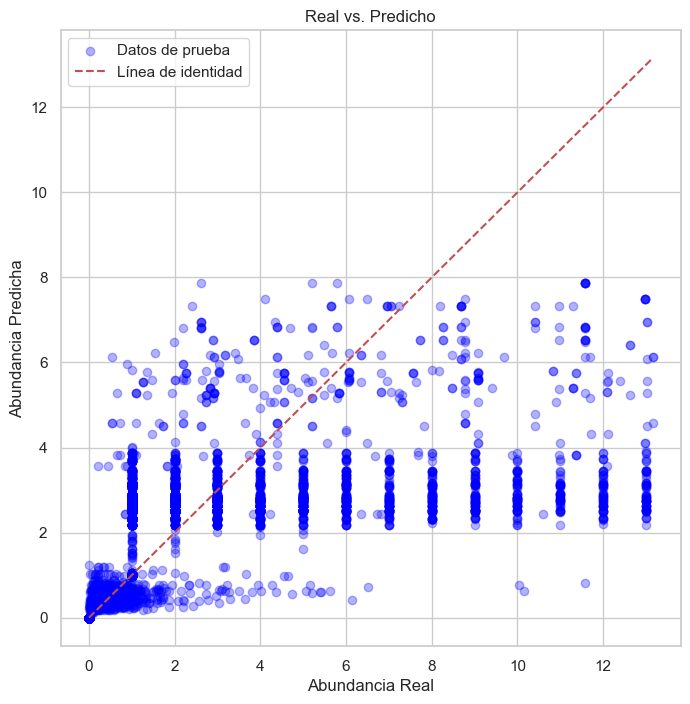

In [177]:
plt.figure(figsize=(8,8))

plt.scatter(y_test_orig, y_pred_orig, alpha=0.3, color='blue', label='Datos de prueba')
# Línea de identidad en log-log es la misma recta
min_val = min(y_test_orig[y_test_orig>0].min(), y_pred_orig[y_pred_orig>0].min())
max_val = max(y_test_orig.max(), y_pred_orig.max())
plt.plot([min_val, max_val], [min_val, max_val], 'r--', label='Línea de identidad')
plt.xlabel("Abundancia Real")
plt.ylabel("Abundancia Predicha")
plt.title("Real vs. Predicho")
plt.legend()
plt.grid(True)
plt.show()


#### Modelo 3

Intentaremos predecir la abundancia por cada clase de TAXA a lo largo de los años.

(array([1940., 1950., 1960., 1970., 1980., 1990., 2000., 2010., 2020.]),
 [Text(1940.0, 0, '1940'),
  Text(1950.0, 0, '1950'),
  Text(1960.0, 0, '1960'),
  Text(1970.0, 0, '1970'),
  Text(1980.0, 0, '1980'),
  Text(1990.0, 0, '1990'),
  Text(2000.0, 0, '2000'),
  Text(2010.0, 0, '2010'),
  Text(2020.0, 0, '2020')])

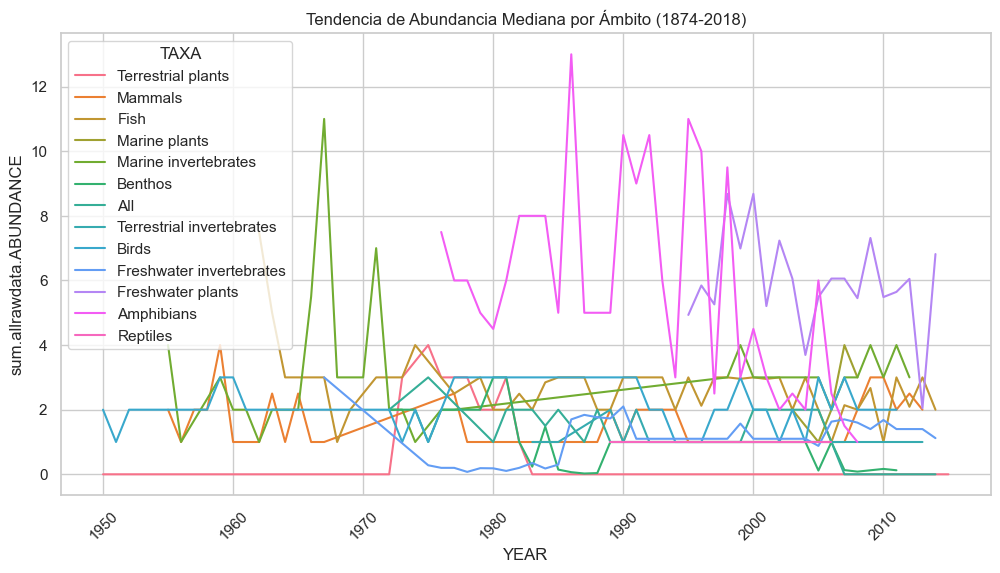

In [187]:
plt.figure(figsize=(12, 6))
sns.lineplot(
    x='YEAR',
    y='sum.allrawdata.ABUNDANCE',
    data=merged_df[(merged_df['YEAR'] >= 1950) & (merged_df['YEAR'] <= 2015)],
    estimator='median',
    errorbar=None,
    hue='TAXA'
)
plt.title('Tendencia de Abundancia Mediana por Ámbito (1874-2018)')
plt.xticks(rotation=45)

Iteration 1, loss = 0.48944954
Validation score: 0.316434
Iteration 2, loss = 0.46800070
Validation score: 0.319240
Iteration 3, loss = 0.46794406
Validation score: 0.319961
Iteration 4, loss = 0.46669984
Validation score: 0.312827
Iteration 5, loss = 0.46736179
Validation score: 0.319200
Iteration 6, loss = 0.46673008
Validation score: 0.315840
Iteration 7, loss = 0.46701629
Validation score: 0.313671
Iteration 8, loss = 0.46657243
Validation score: 0.320094
Iteration 9, loss = 0.46678900
Validation score: 0.317738
Iteration 10, loss = 0.46641355
Validation score: 0.317563
Iteration 11, loss = 0.46644625
Validation score: 0.318445
Iteration 12, loss = 0.46601015
Validation score: 0.318796
Iteration 13, loss = 0.46645672
Validation score: 0.314867
Iteration 14, loss = 0.46668961
Validation score: 0.320011
Iteration 15, loss = 0.46602942
Validation score: 0.318731
Iteration 16, loss = 0.46592347
Validation score: 0.316397
Iteration 17, loss = 0.46546995
Validation score: 0.319650
Iterat

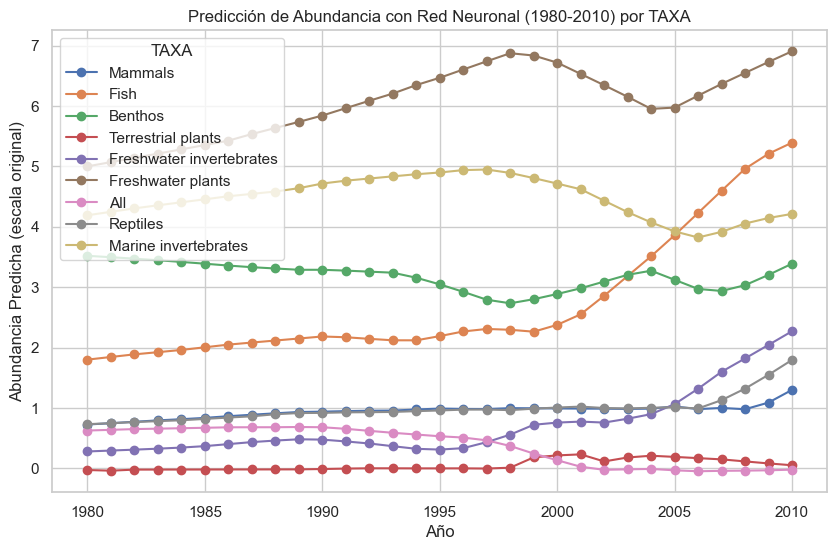

In [221]:
import statsmodels.formula.api as smf
from patsy import bs
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt

# 1. Cargar y limpiar datos
data_filtered = data.copy()

# 2. Definir ABUNDANCE en la escala original
data_filtered["ABUNDANCE"] = data_filtered["sum.allrawdata.ABUNDANCE"]

# 3. Filtrar datos de entrenamiento por rango de años
data_train = data_filtered[(data_filtered['YEAR'] >= 1980) & (data_filtered['YEAR'] <= 2010)].copy()

# 4. Preparar los datos para la red neuronal
from sklearn.preprocessing import StandardScaler, OneHotEncoder
from sklearn.compose import ColumnTransformer
from sklearn.model_selection import train_test_split
from sklearn.neural_network import MLPRegressor
from sklearn.pipeline import Pipeline
from sklearn.metrics import mean_squared_error, r2_score

# Separar características y variable objetivo
X = data_train[['YEAR', 'TAXA']]
y = data_train['ABUNDANCE']

# Dividir en conjuntos de entrenamiento y prueba
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)

# Preprocesamiento: estandarizar variables numéricas y codificar categóricas
preprocessor = ColumnTransformer(
    transformers=[
        ('num', StandardScaler(), ['YEAR']),
        ('cat', OneHotEncoder(handle_unknown='ignore'), ['TAXA'])
    ])

# 5. Crear y entrenar el modelo de red neuronal con scikit-learn
nn_model = Pipeline([
    ('preprocessor', preprocessor),
    ('regressor', MLPRegressor(
        hidden_layer_sizes=(64, 64),  # Dos capas ocultas con 64 neuronas cada una
        activation='relu',
        solver='adam',
        max_iter=1000,
        alpha=0.0001,  # Regularización L2
        random_state=42,
        early_stopping=True,
        validation_fraction=0.1,
        verbose=True
    ))
])

# Entrenar el modelo
nn_model.fit(X_train, y_train)

# 6. Evaluar el modelo
y_pred = nn_model.predict(X_test)
print(f"MSE: {mean_squared_error(y_test, y_pred)}")
print(f"R²: {r2_score(y_test, y_pred)}")

# 7. Crear DataFrame para predicción
years_pred = np.arange(1980, 2011)
taxa_list = data_train['TAXA'].unique()

pred_rows = []
for taxa in taxa_list:
    for year in years_pred:
        pred_rows.append({"YEAR": year, "TAXA": taxa})
df_pred = pd.DataFrame(pred_rows)

# 8. Realizar predicciones
df_pred["ABUNDANCE_PRED"] = nn_model.predict(df_pred)

# 9. Graficar
plt.figure(figsize=(10, 6))
for taxa in taxa_list:
    subset = df_pred[df_pred["TAXA"] == taxa]
    plt.plot(subset["YEAR"], subset["ABUNDANCE_PRED"], marker="o", linestyle="-", label=taxa)

plt.xlabel("Año")
plt.ylabel("Abundancia Predicha (escala original)")
plt.title("Predicción de Abundancia con Red Neuronal (1980-2010) por TAXA")
plt.legend(title="TAXA", loc="upper left")
plt.grid(True)
plt.show()


Rango de años en data_train: 1950 - 2015

Resumen del modelo:
                            OLS Regression Results                            
Dep. Variable:          LOG_ABUNDANCE   R-squared:                       0.172
Model:                            OLS   Adj. R-squared:                  0.172
Method:                 Least Squares   F-statistic:                 1.443e+04
Date:                Mon, 03 Mar 2025   Prob (F-statistic):               0.00
Time:                        00:30:35   Log-Likelihood:            -3.6700e+06
No. Observations:             1526225   AIC:                         7.340e+06
Df Residuals:                 1526202   BIC:                         7.340e+06
Df Model:                          22                                         
Covariance Type:            nonrobust                                         
                                                             coef    std err          t      P>|t|      [0.025      0.975]
-------------------------

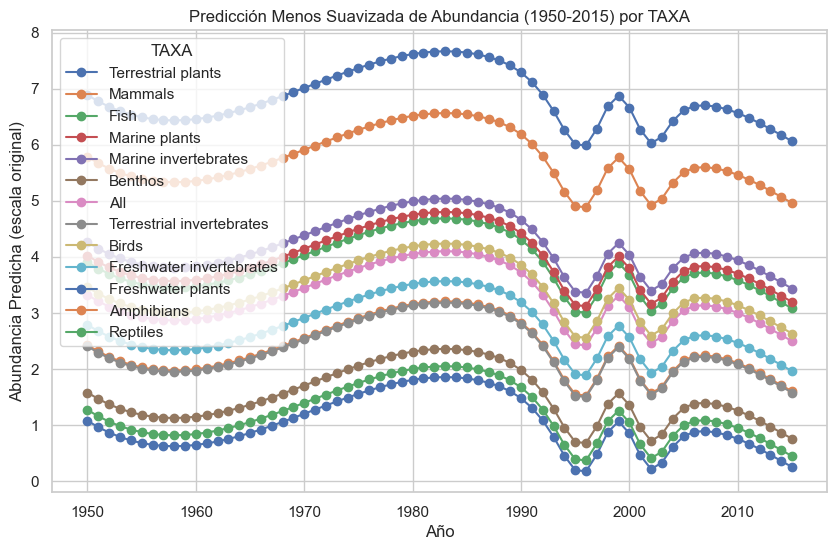

In [222]:
data = merged_df.dropna(subset=['sum.allrawdata.ABUNDANCE']).copy()
data['LOG_ABUNDANCE'] = data['sum.allrawdata.ABUNDANCE'] 

# Eliminamos registros con LOG_ABUNDANCE mayor al percentil 99 para evitar extremos
# threshold = data['LOG_ABUNDANCE'].quantile(0.99)
data_filtered = data.copy()

# Filtrar datos de entrenamiento
data_train = data_filtered[(data_filtered['YEAR'] >= 1950) & (data_filtered['YEAR'] <= 2015)].copy()
print("Rango de años en data_train:", data_train['YEAR'].min(), "-", data_train['YEAR'].max())

# --- 4. Ajustar el modelo ---
# Usamos un spline sobre YEAR con 10 grados de libertad (entre mas grande sea, menos suavizado)
formula = "LOG_ABUNDANCE ~ bs(YEAR, df=10, lower_bound=1950, upper_bound=2015) + C(TAXA)"
model = smf.ols(formula, data=data_train).fit()
print("\nResumen del modelo:")
print(model.summary())

# --- 5. Crear DataFrame para predicción (1950 a 2015) ---
years_pred = np.arange(1950, 2016)  # Predicción para cada año de 1950 a 2015
taxa_list = data_train['TAXA'].unique()  # Todas las categorías presentes en el conjunto filtrado

pred_rows = []
for taxa in taxa_list:
    for year in years_pred:
        pred_rows.append({"YEAR": year, "TAXA": taxa})
df_pred = pd.DataFrame(pred_rows)
print("Rango de años en df_pred:", df_pred['YEAR'].min(), "-", df_pred['YEAR'].max())

# --- 6. Realizar predicciones ---
df_pred["LOG_ABUNDANCE_PRED"] = model.predict(df_pred)
# Convertir a la escala original: abundancia = exp(LOG_ABUNDANCE_PRED) - 1
df_pred["ABUNDANCE_PRED"] = df_pred["LOG_ABUNDANCE_PRED"]

# --- 7. Graficar los resultados ---
plt.figure(figsize=(10, 6))
for taxa in taxa_list:
    subset = df_pred[df_pred["TAXA"] == taxa]
    plt.plot(subset["YEAR"], subset["ABUNDANCE_PRED"], marker="o", linestyle="-", label=taxa)
plt.xlabel("Año")
plt.ylabel("Abundancia Predicha (escala original)")
plt.title("Predicción Menos Suavizada de Abundancia (1950-2015) por TAXA")
plt.legend(title="TAXA", loc="upper left")
plt.grid(True)
plt.show()


## Contaminantes